# Main Subroutines

In [ ]:
#Continue from
#1. Look for ways to run jupyter cell from another cell
#2. Implement Section Large Sphere Model
#3. Run image source slab model to check with Ben

#Naming conventions
#unod represents unod3d and unod2d does not exist due to one node indexing system; always a 1d vector
#u3d_edge and u3d_elem represent uele3d_edge and uele3d_elem in short; each has four columns (first as field; rest as gradient vector)

#Unsolved
#1.distance scaling factor does not work for coupled problems
#2.set_first_kind_bc needs to be updated to accomendate more rows in K
#3.update with_first_kind_bc with the size of faces/edges in 3D implementation
#4.declare numpy type explicitly for function input/output variables
#5.bugs in set_first_kind_bc* need to be fixed (refer to np.where in set_inactive_nodes*)
#6.bugs in assemble_Ks2d and 3d need to be fixed; similar ways to set_first_kind_bc2d in fix bugs section

This spectral induced polarization (SIP) modeling code is dedicated to solve PDEs and the sytems of PDEs of the general type
<center>
    $\nabla\cdot(-c\nabla u-\alpha u+\gamma)+\beta\cdot\nabla u+\alpha u=f$</center>
with the general boundary conditions
<center>
    $-\mathbf n(\cdot\nabla u-\alpha u+\gamma)=g-qu \;\;\;\text{and}$</center>
<center>
    $u=s,$</center>
where $u$ denotes the dependent variable and $\mathbf n$ the inward-pointing unit normal vector.
    

    

## Basic functions

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
#plt.style.use('seaborn-poster')
#plt.style.use('ggplot')

import copy,os,subprocess,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

#set physicsical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]
kF=96485.0 #Faraday's constant [As/mol]

def system_check():
    print('Run system check')
    print('Default numpy.int is %d bits'%np.iinfo(int).bits)
    print('Default numpy.float is %d bits'%np.finfo(float).bits)
    print('')
    return

def scale_mesh(mesh_in,dist_factor):
    print('Scaling distance in mesh')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    mesh=copy.deepcopy(mesh_in)
    mesh['nodes']=mesh['nodes']*dist_factor
    return mesh

def scale_materials(materials_in,dist_factor):
    print('Scaling distance in materials')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    materials=copy.deepcopy(materials_in)

    materials['cx']=materials['cx']/1.0
    materials['cy']=materials['cy']/1.0
    materials['cz']=materials['cz']/1.0

    materials['alpha_x']=materials['alpha_x']/dist_factor
    materials['alpha_y']=materials['alpha_y']/dist_factor
    materials['alpha_z']=materials['alpha_z']/dist_factor

    materials['beta_x']=materials['beta_x']/dist_factor
    materials['beta_y']=materials['beta_y']/dist_factor
    materials['beta_z']=materials['beta_z']/dist_factor

    materials['gamma_x']=materials['gamma_x']/dist_factor
    materials['gamma_y']=materials['gamma_y']/dist_factor
    materials['gamma_z']=materials['gamma_z']/dist_factor

    materials['a']=materials['a']/dist_factor**2
    materials['f']=materials['f']/dist_factor**2
    materials['gs']=materials['gs']/dist_factor
    materials['qs']=materials['qs']/dist_factor
    materials['snod']=materials['snod']/1.0
    materials['anod']=materials['anod']/dist_factor**2
    materials['fnod']=materials['fnod']/dist_factor**2

    return materials

def compute_mids2d_edge(nodes,edges,dist_factor,local):
    #compute middle point of face element (efficiency to be improved)
    nedge=len(edges[:,0])
    midpoints=np.zeros((nedge,4))
    for i in range(0,nedge):
        for j in range(0,2):
            midpoints[i,j]=sum(nodes[edges[i,:],j])/2.0
        
        R=rotate_line(nodes[edges[i,:],:])
        midpoints[i,2:]=R.dot(midpoints[i,:2].T).T
    
    if local:
        midpoints=midpoints[:,2:]
    else:
        midpoints=midpoints[:,:2]

    return midpoints*dist_factor

def compute_mids2d_elem(nodes,elements,dist_factor):
    #compute middle point of 2D element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,2))
    for i in range(0,nelem):
        for j in range(0,2):
            midpoints[i,j]=sum(nodes[elements[i,:],j])/3.0

    return midpoints*dist_factor

def compute_mids3d_face(nodes,faces,dist_factor,local):
    #compute middle point of face element (efficiency to be improved)
    nface=len(faces[:,0])
    midpoints=np.zeros((nface,6))
    for i in range(0,nface):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[faces[i,:],j])/3.0
        
        R=rotate_triangle(nodes[faces[i,:],:])
        midpoints[i,3:]=R.dot(midpoints[i,:3].T).T
        
    if local:
        midpoints=midpoints[:,3:]
    else:
        midpoints=midpoints[:,:3]

    return midpoints*dist_factor

def compute_mids3d_elem(nodes,elements,dist_factor):
    #compute middle point of volume element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,3))
    for i in range(0,nelem):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[elements[i,:],j])/4.0

    return midpoints*dist_factor

def grad2d_edge(nodes,edges,unod,dist_factor,local):
    print('Computing fields and gradients on faces')
    start=time.time()

    nedge=len(edges)
    u2d=np.zeros((nedge,5),dtype=complex)
    Je=np.ones((2,2))
    for i in range(nedge): #consider parallelization
        nind=edges[i,:]
        R=rotate_line(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T

        Je[1:,:]=nodes_new[:,:-1].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes_new[:,0])/2.0
        yr=sum(nodes_new[:,1])/2.0
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr)*unod[nind])

        dudx=sum(unod[nind]*invJe[:,1])
        u2d[i,1:3]=[dudx,0]
        u2d[i,3:5]=np.linalg.inv(R).dot([dudx,0])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    if local:
        u2d=u2d[:,[0,1,2]]
    else:
        u2d=u2d[:,[0,3,4]]

    return u2d*dist_factor

def grad2d_elem(nodes,elements,unod,dist_factor):
    print('Computing fields and gradients in elements')
    start=time.time()

    nelem=len(elements)
    u2d=np.zeros((nelem,3),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes[nind,0])/3.0
        yr=sum(nodes[nind,1])/3.0
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])
        u2d[i,1]=sum(unod[nind]*invJe[:,1])
        u2d[i,2]=sum(unod[nind]*invJe[:,2])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u2d*dist_factor

def grad3d_face(nodes,faces,unod,dist_factor,local):
    print('Computing fields and gradients on faces')
    start=time.time()

    nface=len(faces)
    u3d=np.zeros((nface,7),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nface): #consider parallelization
        nind=faces[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T

        Je[1:,:]=nodes_new[:,:-1].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes_new[:,0])/3.0
        yr=sum(nodes_new[:,1])/3.0
        u3d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])

        dudx=sum(unod[nind]*invJe[:,1])
        dudy=sum(unod[nind]*invJe[:,2])
        u3d[i,1:4]=[dudx,dudy,0]
        u3d[i,4:7]=np.linalg.inv(R).dot([dudx,dudy,0])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    if local:
        u3d=u3d[:,[0,1,2,3]]
    else:
        u3d=u3d[:,[0,4,5,6]]

    return u3d*dist_factor

def grad3d_elem(nodes,elements,unod,dist_factor):
    print('Computing fields and gradients in elements')
    start=time.time()

    nelem=len(elements)
    u3d=np.zeros((nelem,4),dtype=complex)
    Je=np.ones((4,4))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes[nind,0])/4.0
        yr=sum(nodes[nind,1])/4.0
        zr=sum(nodes[nind,2])/4.0
        u3d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr+invJe[:,3]*zr)*unod[nind])
        u3d[i,1]=sum(unod[nind]*invJe[:,1])
        u3d[i,2]=sum(unod[nind]*invJe[:,2])
        u3d[i,3]=sum(unod[nind]*invJe[:,3])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u3d*dist_factor

def rotate_line(nodes):
    #rotate 2D line along vector n to x
    A=np.zeros((3,3))
    R=np.zeros((3,3))

    xnod=nodes[:,0]
    ynod=nodes[:,1]

    n=np.array([xnod[1]-xnod[0],ynod[1]-ynod[0],0])
    length=np.linalg.norm(n)

    n=n/np.linalg.norm(n)
    x=np.array([1,0,0])
    k=np.cross(n,x)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8: #consider improving this line
        k=k/norm_k

        cosb=np.dot(n,x)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)

    return R[:-1,:-1]

def rotate_triangle(nodes):
    #rotate 3D triangle with normal vector n to z
    A=np.zeros((3,3))
    R=np.zeros((3,3))

    xnod=nodes[:,0]
    ynod=nodes[:,1]
    znod=nodes[:,2]

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2

    n=n/np.linalg.norm(n)
    z=np.array([0,0,1])
    k=np.cross(n,z)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8: #consider improving this line
        k=k/norm_k

        cosb=np.dot(n,z)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)

    return R
    
def solve_unod(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    sol=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return sol

def zero_rows(M,rows):
    diag=sparse.eye(M.shape[0]).tolil()
    for r in rows:
        diag[r,r]=0
    #diag[rows,rows]=0
    return diag.dot(M)

def zero_cols(M,cols):
    diag=sparse.eye(M.shape[0]).tolil()
    for c in cols:
        diag[c,c]=0
    #diag[cols,cols]=0
    return M.dot(diag)

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2) #radial distance
    theta=np.arccos(z/rho) #polar angle
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2 #azimuthal angle
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    return rho,theta,phi

def spherical2cartesian(rho,theta,phi):
    x=rho*np.cos(phi)*np.sin(theta)
    y=rho*np.sin(phi)*np.sin(theta)
    z=rho*np.cos(theta)
    return x,y,z

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        nind=np.argmin(dist2)
        output[i,6]=np.real(unod[nind])
        output[i,7]=np.imag(unod[nind])

    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

def reshape_unod(unod_in,coupled,nrep=1):
    #default numpy.reshape order is column major
    if coupled:
        nnode=int(len(unod_in)/nrep/2)
        unod=np.zeros((nnode,nrep*2),dtype=complex)
        unod[:,:nrep]=np.reshape(unod_in[:nnode*nrep],(nnode,nrep))
        unod[:,nrep:]=np.reshape(unod_in[nnode*nrep:],(nnode,nrep))
    else:
        nnode=int(len(unod_in)/nrep)
        unod=np.zeros((nnode,nrep),dtype=complex)
        unod[:,:nrep]=np.reshape(unod_in,(nnode,nrep))
    return unod

if __name__=='__main__':
    system_check()
    print('Done')

Run system check
Default numpy.int is 64 bits
Default numpy.float is 64 bits

Done


## Kernel functions 2D

In [2]:
def assemble_Ke1d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    edges_stern=mesh['edges'][in_stern]
    nnode=len(mesh['nodes'])
    nedge_stern=len(edges_stern)

    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nedge_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nedge_stern):
        nind=edges_stern[i,:]
        R=rotate_line(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        Ke,be=build_Ke1d2d(xnod,gamma_x=gamma_x[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke1d2d(xnod,gamma_x,nrep=1):
    Ke=np.zeros((2*nrep,2*nrep),dtype=complex)
    be=np.zeros(2*nrep,dtype=complex)
    Je=np.ones((2,2))
    Je[1,:]=xnod
    invJe=np.linalg.inv(Je)
    length=np.abs(xnod[1]-xnod[0])

    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         a[kk,ll]*(1+delta_ij)/12.0+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1])*length*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area
        #be is a placeholder; unused

    #don't forget return -Ke instead of Ke
    return -Ke,be

def assemble_Ks2d1d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern

    nodes=mesh['nodes']
    edges_bc=mesh['edges'][with_third_kind_bc,:]
    nnode=len(nodes)
    nedge_bc=len(edges_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nedge_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nedge_bc):
        nind=edges_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ks,bs=build_Ks2d1d(xnod,ynod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks2d1d(xnod,ynod,gs,nrep=1):
    Ks=np.zeros((2*nrep,2*nrep),dtype=complex)
    bs=np.zeros(2*nrep,dtype=complex)

    length=np.sqrt((xnod[1]-xnod[0])**2+(ynod[1]-ynod[0])**2)
    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*length*(1+delta_ij)/6.0
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*length*(1+delta_ij)/6.0
        #bs[i]=gs[kk]*length/2.0
        #bs is a placeholder; unused

    #don't forget return -Ks instead of Ks
    return -Ks,bs

def assemble_Ke1d_edge(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    edges_stern=mesh['edges'][in_stern,:]
    nnode=len(mesh['nodes'])
    nedge_stern=len(edges_stern)

    cx=np.reshape(materials['cx'][in_stern],(nedge_stern,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_stern],(nedge_stern,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_stern],(nedge_stern,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nedge_stern,nrep))
    a=np.reshape(materials['a'][in_stern],(nedge_stern,nrep,nrep))
    f=np.reshape(materials['f'][in_stern],(nedge_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nedge_stern):
        nind=edges_stern[i,:]
        R=rotate_line(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        Ke,be=build_Ke1d_edge(xnod,cx=cx[i],alpha_x=alpha_x[i],beta_x=beta_x[i],
            gamma_x=gamma_x[i],a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke1d_edge(xnod,cx,alpha_x,beta_x,gamma_x,a,f,nrep=1):
    Ke=np.zeros((2*nrep,2*nrep),dtype=complex)
    be=np.zeros(2*nrep,dtype=complex)
    Je=np.ones((2,2))
    Je[1,:]=xnod
    invJe=np.linalg.inv(Je)
    length=np.abs(xnod[1]-xnod[0])

    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+
                     a[kk,ll]*(1+delta)/6.0+
                     (alpha_x[kk,ll]*invJe[ii,1])/2.0+
                     (beta_x[kk,ll]*invJe[jj,1])/2.0)*length
        be[i]=(gamma_x[kk]*invJe[ii,1]+f[kk]/2.0)*length

    return Ke,be

def assemble_Ke2d_elem(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']

    nodes=mesh['nodes']
    elements_active=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_active=len(elements_active)

    cx=np.reshape(materials['cx'][in_active_zones],(nelem_active,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_active,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_active,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_active,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_active,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_active,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_active,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_active,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_active,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_active,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_active*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_active*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_active*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nelem_active):
        nind=elements_active[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ke,be=build_Ke2d_elem(xnod,ynod,cx=cx[i],cy=cy[i],
            alpha_x=alpha_x[i],alpha_y=alpha_y[i],
            beta_x=beta_x[i],beta_y=beta_y[i],
            gamma_x=gamma_x[i],gamma_y=gamma_y[i],
            a=a[i],f=f[i],anod=anod[nind],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke2d_elem(xnod,ynod,cx,cy,alpha_x,alpha_y,beta_x,beta_y,
        gamma_x,gamma_y,a,f,anod,fnod,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     a[kk,ll]*(1+delta)/12.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0+
                     anod[jj,kk,ll]*(1+delta)/12.0)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

        for jj in range(3):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*area*(1+delta)/12.0

    return Ke,be

def assemble_Ks2d_edge(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=np.reshape(mesh['with_third_kind_bc'],(-1,nrep))
    with_third_kind_bc=np.any(with_third_kind_bc,axis=1) #temporary solution

    nodes=mesh['nodes']
    edges_bc=mesh['edges'][with_third_kind_bc,:]
    nnode=len(nodes)
    nedge_bc=len(edges_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nedge_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nedge_bc,nrep,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nedge_bc):
        nind=edges_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ks,bs=build_Ks2d_edge(xnod,ynod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks2d_edge(xnod,ynod,gs,qs,nrep=1):
    Ks=np.zeros((2*nrep,2*nrep),dtype=complex)
    bs=np.zeros(2*nrep,dtype=complex)

    length=np.sqrt((xnod[1]-xnod[0])**2+(ynod[1]-ynod[0])**2)
    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*length*(1+delta)/6.0
        bs[i]=gs[kk]*length/2.0

    return Ks,bs

def set_first_kind_bc2d_node(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    nodes=mesh['nodes']
    on_first_kind_bc=mesh['on_first_kind_bc']
    nind_bc=np.where(on_first_kind_bc)[0]
    nind_in=np.where(~on_first_kind_bc)[0]
    nodes_bc=nodes[nind_bc,:]

    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    snod=np.reshape(materials['snod'][nind_bc],(nnode_bc,nrep))

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_first_kind_bc2d_edge(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    nodes=mesh['nodes']
    edges=mesh['edges']
    with_first_kind_bc=np.reshape(mesh['with_first_kind_bc'],(-1,nrep))
    nnode=len(nodes)
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    
    for irep in range(nrep):
        nind_bc=np.unique(edges[with_first_kind_bc[:,irep],:].flatten(order='C'))
        mask_in=np.ones(nnode,dtype=bool)
        mask_in[nind_bc]=False
        nind_in=np.where(mask_in)[0]
        nodes_bc=nodes[nind_bc,:]

        nnode_bc=len(nodes_bc)
        snod=np.reshape(materials['snod'][nind_bc],(nnode_bc,nrep))[:,irep]
        REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

        for i in nind_in:
            rows=REP[i,:].flatten(order='C')+offset[0]
            cols=REP[nind_bc,irep].flatten(order='C')+offset[1]
            #may need to expand cols by including the coupled rows in K and b
            for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
                b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

        rows=REP[nind_bc,irep].flatten(order='C')+offset[0]
        cols=REP[nind_bc,irep].flatten(order='C')+offset[1]
        #reduce rows and cols by checking True or False in with_first_kind_bc
        M=csr_matrix(K.shape).tolil()
        M[rows,cols]=1.0
        K=zero_rows(K,rows)
        K=zero_cols(K,cols)
        K=K+M
        b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_inactive_nodes2d_edge(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    edges=mesh['edges']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(edges[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]

    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes2d_elem(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])

    nind_active=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_active]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]

    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

if __name__=='__main__':
    print('Done')

Done


## Kernel functions 3D

In [ ]:
def assemble_Ke2d3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)

    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d3d(xnod,ynod,gamma_x=gamma_x[i],
                           gamma_y=gamma_y[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke2d3d(xnod,ynod,gamma_x,gamma_y,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         a[kk,ll]*(1+delta_ij)/12.0+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1]+
                     gamma_y[kk]*invJe[ii,2]*invJe[jj,2])*area*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area
        #be is a placeholder; unused

    #don't forget return -Ke instead of Ke
    return -Ke,be

def assemble_Ks3d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern

    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d2d(xnod,ynod,znod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks3d2d(xnod,ynod,znod,gs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*area*(1+delta_ij)/12.0
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*area*(1+delta_ij)/12.0
        #bs[i]=gs[kk]*area/3
        #bs is a placeholder; unused

    #don't forget return -Ks instead of Ks
    return -Ks,bs

def assemble_Ke2d_face(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern,:]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)

    cx=np.reshape(materials['cx'][in_stern],(nface_stern,nrep,nrep))
    cy=np.reshape(materials['cy'][in_stern],(nface_stern,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_stern],(nface_stern,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_stern],(nface_stern,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_stern],(nface_stern,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_stern],(nface_stern,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
    a=np.reshape(materials['a'][in_stern],(nface_stern,nrep,nrep))
    f=np.reshape(materials['f'][in_stern],(nface_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d_face(xnod,ynod,cx=cx[i],cy=cy[i],
            alpha_x=alpha_x[i],alpha_y=alpha_y[i],
            beta_x=beta_x[i],beta_y=beta_y[i],
            gamma_x=gamma_x[i],gamma_y=gamma_y[i],
            a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke2d_face(xnod,ynod,cx,cy,alpha_x,alpha_y,
        beta_x,beta_y,gamma_x,gamma_y,a,f,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     a[kk,ll]*(1+delta)/12.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

    return Ke,be

def assemble_Ke3d_elem(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']

    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)

    cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
    cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
    gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d_elem(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
            alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
            beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
            gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
            a=a[i],f=f[i],anod=anod[nind],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke3d_elem(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
        beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,anod,fnod,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6.0

    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4.0+
                     anod[jj,kk,ll]*(1+delta)/20.0)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4.0)*vol

        for jj in range(4):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*vol*(1+delta)/20

    return Ke,be

def assemble_Ks3d_face(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']

    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nface_bc,nrep,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d_face(xnod,ynod,znod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks3d_face(xnod,ynod,znod,gs,qs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*area*(1+delta)/12.0
        bs[i]=gs[kk]*area/3.0

    return Ks,bs

def set_first_kind_bc3d_node(): #placeholder
    
    return

def set_first_kind_bc3d_face(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #to be modified
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    nodes=mesh['nodes']
    faces=mesh['faces']
    with_first_kind_bc=mesh['with_first_kind_bc'] #this will be changed from node index to face index

    nodes_bc=mesh['nodes'][with_first_kind_bc]
    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    snod=np.reshape(materials['snod'][with_first_kind_bc],(nnode_bc,nrep))

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_bc=np.where(with_first_kind_bc)[0]
    nind_in=np.where(~with_first_kind_bc)[0]

    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes3d_face(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    faces=mesh['faces']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(faces[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=0

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]

    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes3d_elem(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])

    nind_in=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_in]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]

    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

if __name__=='__main__':
    print('Done')

## Analytical solutions

In [ ]:
def anso_slab(z,a,rel_perm,temp_K,cinf,zval,zeta,gradflag):
    print('Computing 1D linar PB solution in cartesian coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT INTERFACE IS:',zeta)
    else:
        print('POTENTIAL AT INTERFACE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')

    if gradflag:
        zeta=zeta*debye_len/perm0/rel_perm
        
    u=np.zeros((len(z),4))
    mask=z>=a
    u[mask,0]=zeta*np.exp(-z/debye_len)
    u[~mask,0]=zeta
    return u

def ansol_sphere(r,a,rel_perm,temp_K,cinf,zval,zeta,gradflag):
    print('Computing 1D linar PB solution in spherical coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('SOLID PARTICLE RADIUS IS:',a)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT SPHERE IS:',zeta)
    else:
        print('POTENTIAL AT SPHERE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')

    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm

    dist=np.sqrt(r[:,0]**2+r[:,1]**2+r[:,2]**2)
    u=np.zeros((len(dist),4))
    mask=dist>=a
    u[mask,0]=zeta*a*np.exp((a-dist[mask])/debye_len)/dist[mask]
    u[~mask,0]=zeta
    u[mask,1]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,0]/dist[mask]
    u[mask,2]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,1]/dist[mask]
    u[mask,3]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,2]/dist[mask]
    return u

if __name__=='__main__':
    print('Done')

## External functions

In [15]:
#https://gist.github.com/venuktan/8910385
import numpy as N
import scipy as S
def coo_submatrix_pull(matr, rows, cols):
    """
    Pulls out an arbitrary i.e. non-contiguous submatrix out of
    a sparse.coo_matrix. 
    """
    if type(matr) != S.sparse.coo_matrix:
        raise TypeError('Matrix must be sparse COOrdinate format')
    
    gr = -1 * N.ones(matr.shape[0])
    gc = -1 * N.ones(matr.shape[1])
    
    lr = len(rows)
    lc = len(cols)
    
    ar = N.arange(0, lr)
    ac = N.arange(0, lc)
    gr[rows[ar]] = ar
    gc[cols[ac]] = ac
    mrow = matr.row
    mcol = matr.col
    newelem = (gr[mrow] > -1) & (gc[mcol] > -1)
    newrows = mrow[newelem]
    newcols = mcol[newelem]
    return S.sparse.coo_matrix((matr.data[newelem], N.array([gr[newrows],
        gc[newcols]])),(lr, lc))

#https://empymod.emsig.xyz/en/stable/manual/usage.html
from scipy import special, fftpack, integrate
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline
def fourier_fftlog(fEM, time, freq, ftarg):
    r"""Fourier Transform using FFTLog.
    FFTLog is the logarithmic analogue to the Fast Fourier Transform FFT.
    FFTLog was presented in Appendix B of [Hami00]_ and published at
    http://casa.colorado.edu/~ajsh/FFTLog.
    This function uses a simplified version of `pyfftlog`, which is a
    python-version of `FFTLog`. For more details regarding `pyfftlog` see
    https://github.com/prisae/pyfftlog.
    Not the full flexibility of `FFTLog` is available here: Only the
    logarithmic FFT (`fftl` in `FFTLog`), not the Hankel transform
    (:func:`hankel_dlf` in `FFTLog`). Furthermore, the following parameters are
    fixed:
    - `kr` = 1 (initial value)
    - `kropt` = 1 (silently adjusts `kr`)
    - `dir` = 1 (forward)
    Furthermore, `q` is restricted to -1 <= q <= 1.
    The function is called from one of the modelling routines in
    :mod:`empymod.model`. Consult these modelling routines for a description of
    the input and output parameters.
    Returns
    -------
    tEM : array
        Returns time-domain EM response of `fEM` for given `time`.
    conv : bool
        Only relevant for QWE/QUAD.
    """
    # Get tcalc, dlnr, kr, rk, q; a and n
    q = ftarg['q']
    mu = ftarg['mu']
    tcalc = ftarg['tcalc']
    dlnr = ftarg['dlnr']
    kr = ftarg['kr']
    rk = ftarg['rk']

    if mu > 0:  # Sine
        a = -fEM.imag
    else:       # Cosine
        a = fEM.real
    n = a.size

    # 1. Amplitude and Argument of kr^(-2 i y) U_mu(q + 2 i y)
    ln2kr = np.log(2.0/kr)
    d = np.pi/(n*dlnr)
    m = np.arange(1, (n+1)/2)
    y = m*d  # y = m*pi/(n*dlnr)

    if q == 0:  # unbiased case (q = 0)
        zp = special.loggamma((mu + 1)/2.0 + 1j*y)
        arg = 2.0*(ln2kr*y + zp.imag)

    else:       # biased case (q != 0)
        xp = (mu + 1.0 + q)/2.0
        xm = (mu + 1.0 - q)/2.0

        zp = special.loggamma(xp + 0j)
        zm = special.loggamma(xm + 0j)

        # Amplitude and Argument of U_mu(q)
        amp = np.exp(np.log(2.0)*q + zp.real - zm.real)
        # note +Im(zm) to get conjugate value below real axis
        arg = zp.imag + zm.imag

        # first element: cos(arg) = ±1, sin(arg) = 0
        argcos1 = amp*np.cos(arg)

        # remaining elements
        zp = special.loggamma(xp + 1j*y)
        zm = special.loggamma(xm + 1j*y)

        argamp = np.exp(np.log(2.0)*q + zp.real - zm.real)
        arg = 2*ln2kr*y + zp.imag + zm.imag

    argcos = np.cos(arg)
    argsin = np.sin(arg)

    # 2. Centre point of array
    jc = np.array((n + 1)/2.0)
    j = np.arange(n)+1

    # 3. a(r) = A(r) (r/rc)^[-dir*(q-.5)]
    a *= np.exp(-(q - 0.5)*(j - jc)*dlnr)

    # 4. transform a(r) -> ã(k)

    # 4.a normal FFT
    a = fftpack.rfft(a)

    # 4.b
    m = np.arange(1, n//2, dtype=np.int64)  # index variable
    if q == 0:  # unbiased (q = 0) transform
        # multiply by (kr)^[- i 2 m pi/(n dlnr)] U_mu[i 2 m pi/(n dlnr)]
        ar = a[2*m-1]
        ai = a[2*m]
        a[2*m-1] = ar*argcos[:-1] - ai*argsin[:-1]
        a[2*m] = ar*argsin[:-1] + ai*argcos[:-1]
        # problematical last element, for even n
        if np.mod(n, 2) == 0:
            ar = argcos[-1]
            a[-1] *= ar

    else:  # biased (q != 0) transform
        # multiply by (kr)^[- i 2 m pi/(n dlnr)] U_mu[q + i 2 m pi/(n dlnr)]
        # phase
        ar = a[2*m-1]
        ai = a[2*m]
        a[2*m-1] = ar*argcos[:-1] - ai*argsin[:-1]
        a[2*m] = ar*argsin[:-1] + ai*argcos[:-1]

        a[0] *= argcos1
        a[2*m-1] *= argamp[:-1]
        a[2*m] *= argamp[:-1]

        # problematical last element, for even n
        if np.mod(n, 2) == 0:
            m = int(n/2)-3
            ar = argcos[m-1]*argamp[m-1]
            a[-1] *= ar

    # 4.c normal FFT back
    a = fftpack.irfft(a)

    # Ã(k) = ã(k) k^[-dir*(q+.5)] rc^[-dir*(q-.5)]
    #      = ã(k) (k/kc)^[-dir*(q+.5)] (kc rc)^(-dir*q) (rc/kc)^(dir*.5)
    a = a[::-1]*np.exp(-((q + 0.5)*(j - jc)*dlnr + q*np.log(kr) -
                       np.log(rk)/2.0))

    # Interpolate for the desired times
    ttEM = iuSpline(np.log(tcalc), a)
    tEM = ttEM(np.log(time))

    # (Second argument is only for QWE)
    return tEM, True

def fourier_fft(fEM, time, freq, ftarg):
    r"""Fourier Transform using the Fast Fourier Transform.
    The function is called from one of the modelling routines in
    :mod:`empymod.model`. Consult these modelling routines for a description of
    the input and output parameters.
    Returns
    -------
    tEM : array
        Returns time-domain EM response of `fEM` for given `time`.
    conv : bool
        Only relevant for QWE/QUAD.
    """
    # Get ftarg values
    dfreq = ftarg['dfreq']
    nfreq = ftarg['nfreq']
    ntot = ftarg['ntot']
    pts_per_dec = ftarg['pts_per_dec']

    # If pts_per_dec, we have first to interpolate fEM to required freqs
    if pts_per_dec:
        sfEMr = iuSpline(np.log(freq), fEM.real)
        sfEMi = iuSpline(np.log(freq), fEM.imag)
        freq = np.arange(1, nfreq+1)*dfreq
        fEM = sfEMr(np.log(freq)) + 1j*sfEMi(np.log(freq))

    # Pad the frequency result
    fEM = np.pad(fEM, (0, ntot-nfreq), 'linear_ramp')

    # Carry out FFT
    ifftEM = fftpack.ifft(np.r_[fEM[1:], 0, fEM[::-1].conj()]).real
    stEM = 2*ntot*fftpack.fftshift(ifftEM*dfreq, 0)

    # Interpolate in time domain
    dt = 1/(2*ntot*dfreq)
    ifEM = iuSpline(np.linspace(-ntot, ntot-1, 2*ntot)*dt, stEM)
    tEM = ifEM(time)/2*np.pi  # (Multiplication of 2/pi in model.tem)

    # Return the electromagnetic time domain field
    # (Second argument is only for QWE)
    return tEM, True

def get_fftlog_input(rmin, rmax, n, q, mu):
    r"""Return parameters required for FFTLog."""

    # Central point log10(r_c) of periodic interval
    logrc = (rmin + rmax)/2

    # Central index (1/2 integral if n is even)
    nc = (n + 1)/2.

    # Log spacing of points
    dlogr = (rmax - rmin)/n
    dlnr = dlogr*np.log(10.)

    # Get low-ringing kr
    y = 1j*np.pi/(2.0*dlnr)
    zp = special.loggamma((mu + 1.0 + q)/2.0 + y)
    zm = special.loggamma((mu + 1.0 - q)/2.0 + y)
    arg = np.log(2.0)/dlnr + (zp.imag + zm.imag)/np.pi
    kr = np.exp((arg - np.round(arg))*dlnr)

    # Calculate required input x-values (freq); angular freq -> freq
    freq = 10**(logrc + (np.arange(1, n+1) - nc)*dlogr)/(2*np.pi)

    # Calculate tcalc with adjusted kr
    logkc = np.log10(kr) - logrc
    tcalc = 10**(logkc + (np.arange(1, n+1) - nc)*dlogr)

    # rk = r_c/k_r; adjust for Fourier transform scaling
    rk = 10**(logrc - logkc)*np.pi/2

    return freq, tcalc, dlnr, kr, rk

if __name__=='__main__':
    print('Done')

Done


## List of variables

In [ ]:
#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
%whos module

In [7]:
#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
%whos function

Variable                    Type        Data/Info
-------------------------------------------------
assemble_Ke1d2d             function    <function assemble_Ke1d2d at 0x7fa5cffafaf0>
assemble_Ke1d_edge          function    <function assemble_Ke1d_edge at 0x7fa5cffaff70>
assemble_Ke2d_elem          function    <function assemble_Ke2d_elem at 0x7fa6080d20d0>
assemble_Ks2d1d             function    <function assemble_Ks2d1d at 0x7fa5cffaf9d0>
assemble_Ks2d_edge          function    <function assemble_Ks2d_edge at 0x7fa6080d21f0>
build_Ke1d2d                function    <function build_Ke1d2d at 0x7fa5cffafa60>
build_Ke1d_edge             function    <function build_Ke1d_edge at 0x7fa6080d2040>
build_Ke2d_elem             function    <function build_Ke2d_elem at 0x7fa6080d2160>
build_Ks2d1d                function    <function build_Ks2d1d at 0x7fa5cffaf940>
build_Ks2d_edge             function    <function build_Ks2d_edge at 0x7fa6080d2280>
cartesian2spherical         function    <functi

In [ ]:
#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
%whos str int float dict

In [ ]:
#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
%whos ndarray

# Templates

# Sphere Model (Thick DL)

## Radial discretization <a id="3.1"></a>

DEBYE LENGTH IS: 9.63e+00 nm
Ratio of radius to Debye length is: 10.387250538743286
See radial discretization below
[0.00000000e+00 1.00000000e-07 1.00127232e-07 1.00192544e-07
 1.00291381e-07 1.00440953e-07 1.00667303e-07 1.01009845e-07
 1.01528221e-07 1.02312690e-07 1.03499844e-07 1.05296391e-07
 1.08015145e-07 1.12129495e-07 1.18355831e-07 1.27778283e-07
 1.42037485e-07 1.63616249e-07 1.96271867e-07 2.45690330e-07
 3.20476375e-07 4.00000000e-07]
7.853981633974483e-10 1.2723249837093867e-10


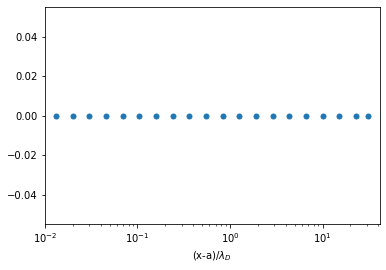

Done


In [4]:
def discretize_grid():
    a=0.1e-6
    #debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    debye_len=np.sqrt(perm0*80*kB*293/2/1**2/echarge**2/kA/1)
    print('DEBYE LENGTH IS: %.2e nm'%(debye_len*1e9))
    print('Ratio of radius to Debye length is:',a/debye_len)

    rho=np.logspace(np.log10(0.02),1,16)*debye_len+a
    dr=np.diff(np.log10((rho-a)/debye_len))[0]
    rho=np.power(10,np.arange(np.log10(0.02)-dr,1+dr*2,dr))*debye_len+a
    rho=np.r_[0,a,rho,4*a]
    print('See radial discretization below')
    print(rho)
    print(np.pi*a/400,rho[2]-a)
    
    fig,ax=plt.subplots()
    mask=rho>a
    ax.plot((rho[mask]-a)/debye_len,np.zeros_like(rho[mask]),'o',markersize=5)
    ax.set_xscale('log')
    ax.set_xlim(0.01,4*a/debye_len)
    ax.set_xlabel('(x-a)/$\lambda_D$')
    plt.show()
    
    return rho

if __name__=='__main__':
    rho=discretize_grid()
    #print(rho)
    print('Done')

## Mesh generation <a id="3.2"></a>

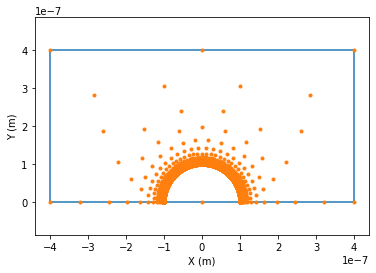

Opening sphere_small.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  9
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  14

Writing sphere_small.1.node.
Writing sphere_small.1.ele.
Writing sphere_small.1.poly.
Writing sphere_small.1.edge.
Writing sphere_small.1.neigh.

Output milliseconds:  28
Total running milliseconds:  57

Statistics:

  Input vertices: 4007
  Input segments: 445
  Input holes: 0

  Mesh vertices: 9432
  Mesh triangles: 18724
  Mesh edges: 28155
  Mesh exterior boundary edges: 138
  Mesh interior boundary edges: 835
  Mesh subsegments (constrained edges): 973

Done


In [6]:
import subprocess

def generate_mesh():
    a = 0.1e-6 #radius of the particle
    cpts = np.zeros((0,3)) #coord_x/coord_y/flag of control points
    
    #define the inner sphere points
    #centered at (0,0) with radius a
    dA = max(np.pi*a/400,rho[2]-a)/a
    nA = np.ceil(np.pi/dA)
    ns = nA+1-2
    
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA #half the circle
    x = a*np.cos(phi)+0.0
    y = a*np.sin(phi)+0.0
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the outer corner points
    x = np.r_[np.flipud(-rho),rho[1:]]
    y = np.zeros(len(rho)*2-1)
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*3]] #node flag of 3
    
    x = [4*a,-4*a]
    y = [4*a,4*a]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*4]] #node flag of 4
    
    #define the inner refined points
    for i in range(3,len(rho)):
        dA = max(np.pi*a/400,rho[i]-rho[i-1])/a
        nA = np.ceil(np.pi/dA)
        ns = nA+1-2
        
        dA = np.pi/nA
        phi = np.arange(1,ns+1)*dA
        x = rho[i]*np.cos(phi)+0.0
        y = rho[i]*np.sin(phi)+0.0
        cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0

    #define the segments along the inner sphere
    #centered at (0,0) with radius a
    segs = np.zeros((0,3)) #ind_a/ind_b/flag of line segmenets
    dA = max(np.pi*a/400,rho[2]-a)/a
    nA = np.ceil(np.pi/dA)
    ns = nA+1-2
    
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA #half the circle
    x = np.r_[a,a*np.cos(phi)+0.0,-a]
    y = np.r_[0,a*np.sin(phi)+0.0,0]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,1]] #edge flag of 1
    
    #define the segments on the bottom of outer boundary (y of 0)
    x = np.r_[np.flipud(-rho),rho[1:]]
    y = np.zeros(len(rho)*2-1)
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,3]] #edge flag of 3
        
    #define the segmesnts on the right side of the outer boundary (x of 4a)
    x = [4*a,4*a]
    y = [0,4*a]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,4]] #edge flag of 4
    
    #define the segments on the top of the outer boundary (y of 4a)
    x = [4*a,-4*a]
    y = [4*a,4*a]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,5]] #edge flag of 5

    #define the segments on the left of the outer boundary (x of -4a)
    x = [-4*a,-4*a]
    y = [4*a,0]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,6]] #edge flag of 6

    fig,ax=plt.subplots()
    x=cpts[segs[:,:-1].astype(int),0]
    y=cpts[segs[:,:-1].astype(int),1]
    ax.plot(x.T,y.T,'-',color='tab:blue')
    ax.plot(cpts[:,0],cpts[:,1],'.',color='tab:orange')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
#     ax.set_xlim(-50e-9,50e-9)
#     ax.set_ylim(-50e-9,50e-9)
# #     ax.set_xlim(-1e-9,1e-9)
# #     ax.set_ylim(-1e-9,1e-9)
    plt.show()
    
    #build the poly file
    f1 = open('sphere_small.poly','w')
    f1.write(str(len(cpts))+'  2 0 1  #verticies #dimensions  #attributes #boundary markers \n')
    
    #write the vertices
    cnt = 1
    for i in range(len(cpts)):
        f1.write("{0:6.0F} {1:20.5F} {2:20.5F} {3:6.0F}\n".format(cnt,cpts[i,0]*1e6,cpts[i,1]*1e6,cpts[i,2]))
        cnt = cnt+1
    f1.write('\n\n')

    #write the segments
    cnt = 1
    f1.write(str(len(segs))+' 1 #segments, boundary marker\n')
    for i in range(len(segs)):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} {3:6.0F}\n".format(cnt,segs[i,0]+1,segs[i,1]+1,segs[i,2]))
        cnt = cnt+1

    #holes
    f1.write('\n\n0\n\n')
    #f1.write('1 {0:12.6F} {1:12.6F} 1\n\n'.format(0.0,0.5e6*a))

    #area constraints for each of 2 zones
    f1.write('2\n')
    f1.write('1 {0:12.6F} {1:12.6F} 1 {2:12.6F}\n'.format(0.0,0.5e6*a,1e12))
    f1.write('2 {0:12.6F} {1:12.6F} 2 {2:12.6F}\n'.format(0.0,2e6*a,(4e6*a/20)**2))

    f1.write('# triangle -pnq30Aae sphere_small.poly \n')
    f1.close()
    
    return cpts,segs

if __name__=='__main__':
    cpts,segs=generate_mesh()
    process=subprocess.Popen(['triangle -pnq30Aae sphere_small.poly'],shell=True)
    process.wait()

    print('Done')

## Mesh visualization <a id="3.3"></a>

Reading sphere_small.1.node
Reading sphere_small.1.ele
Reading sphere_small.1.edge
THE NUMBER OF NODES IS: 9432
THE NUMBER OF ELEMENTS IS: 18724
THE NUMBER OF EDGES IS: 28155
THE NUMBER OF ZONES IS: 2
zones [1 2]
edge_flags [0 1 3 4 5 6]



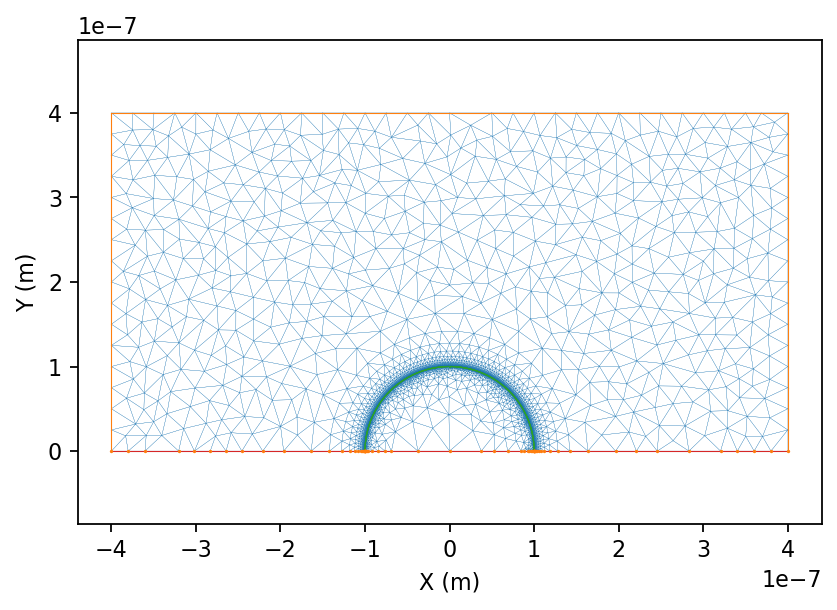

In [7]:
def display_mesh():
    #modify user inputs below
    mesh_prefix='sphere_small'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1
    
    #scale nodes from meter to micro-meter
    nodes=nodes*1e-6
    
    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('THE NUMBER OF ZONES IS: %d'%len(np.unique(zones)))
    print('zones',np.unique(zones))
    print('edge_flags',np.unique(edge_flags))
    print('')
    
    fig,ax=plt.subplots(dpi=160)
    mask=zones>=1 #select zones to display
    x=nodes[elements[:,[0,1,2,0]],0]
    y=nodes[elements[:,[0,1,2,0]],1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.1,color='tab:blue')    
    
    mask=edge_flags==1
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:green')
    
    mask=edge_flags==3
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:red')

    mask=edge_flags>=4
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:orange')

#     mask=node_flags==1
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:green')
#     mask=node_flags==2
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:red')
    mask=node_flags==3
    ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:orange')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
#     ax.set_xlim(5,5.25)
#     ax.set_ylim(0,0.25)
    return fig,ax

if __name__=='__main__':
    fig,ax=display_mesh()
#     nodes=mesh['nodes']
#     elements=mesh['elements']
#     edges=mesh['edges']
#     with_first_kind_bc=mesh['with_first_kind_bc']
#     with_third_kind_bc=mesh['with_third_kind_bc']
#     in_stern=mesh['in_stern']
    
#     nind_bc=np.unique(edges[with_first_kind_bc,:].flatten(order='C'))
#     x=nodes[nind_bc,0]
#     y=nodes[nind_bc,1]
#     ax.plot(x,y,'.',color='tab:orange',markersize=0.5)
    
#     x=nodes[edges[with_third_kind_bc,:],0]
#     y=nodes[edges[with_third_kind_bc,:],1]
#     ax.plot(x.T,y.T,'-',linewidth=0.5,color='tab:red')
    plt.show()


## Mesh properties

In [3]:
nrep=3

def set_mesh():
    #modify user inputs below
    mesh_prefix='sphere_small'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1

    #scale nodes from meter to micro-meter
    nodes=nodes*1e-6

    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('THE NUMBER OF ZONES IS: %d'%len(np.unique(zones)))
    print('zones',np.unique(zones))
    print('edge_flags',np.unique(edge_flags))
    print('')

    #define computational volume elements
    in_active_zones=zones==2 #True for elements used in computation
    
    #define boundary edge elements
    with_first_kind_bc=np.zeros((nedge,nrep),dtype=bool) #True for edges on first kind b.c.
    with_third_kind_bc=np.zeros((nedge,nrep),dtype=bool) #True for edges on third kind b.c.
    
    with_first_kind_bc[:,0]=(edge_flags>=4)
    with_first_kind_bc[:,1]=(edge_flags>=4)
    with_first_kind_bc[:,2]=(edge_flags>=4)|(edge_flags==1)
    
    with_third_kind_bc[:,0]=(edge_flags==1)
    with_third_kind_bc[:,1]=(edge_flags==1)
    with_third_kind_bc[:,2]=False
    
    #define electrolyte,solid,stern layer
    in_electrolyte=zones==2
    in_solid=zones==1
    in_stern=edge_flags==-1
    
    #more properties
    with_inner_bound=edge_flags==1
    with_outer_bound=edge_flags>=3
    with_top_bound=edge_flags==5
    with_bottom_bound=edge_flags==3
    with_left_bound=edge_flags==6
    with_right_bound=edge_flags==4
    on_survey_lines=node_flags==3
    
    nind_active=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(edges[in_stern,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_active))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES IN STERN LAYER IS:',len(nind_stern))
    print('THE NUMBER OF ELEMENTS IN STERN LAYER IS:',np.count_nonzero(in_stern))
    print('')
    
    for i in range(nrep):
        nind_bc=np.unique(edges[with_first_kind_bc[:,i],:].flatten(order='C'))
        print(str(i+1),'THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',len(nind_bc))
    print('')
    
    for i in range(nrep):
        nind_bc=np.unique(edges[with_third_kind_bc[:,i],:].flatten(order='C'))
        print(str(i+1),'THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',len(nind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'edges':edges,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern,
          'with_inner_bound':with_inner_bound,
          'with_outer_bound':with_outer_bound,
          'with_top_bound':with_top_bound,
          'with_bottom_bound':with_bottom_bound,
          'with_left_bound':with_left_bound,
          'with_right_bound':with_right_bound,
          'on_survey_lines':on_survey_lines}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=80.0 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    #diffusion_electrolyte=2*1e-9 #diffusion coefficient of water at 20 deg. C is 2*(1e-6*m)^2/(1e-3*s)
    #diffusion_stern=2*1e-10 #diffusion coefficient in Stern layer [m^2/s]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-9 #mobility in Stern layer [m^2/(Vs)]
    sigma_solid=-0.01 #surface charge density in solid [C/m^2]
    
    temp_K=293 #room/ambient temperature [K]
    cinf=1.0 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence
    
    #diffusion coefficient based on Einstein relation
    diffusion_electrolyte=mobility_electrolyte*kB*temp_K/echarge
    diffusion_stern=mobility_stern*kB*temp_K/echarge

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR SOLID IS:',sigma_solid)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_solid':sigma_solid,'debye_len':debye_len,
             'sigma_electrolyte':None,'sigma_stern':None,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}
    
    return physics

if __name__=='__main__':
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

Reading sphere_small.1.node
Reading sphere_small.1.ele
Reading sphere_small.1.edge
THE NUMBER OF NODES IS: 9432
THE NUMBER OF ELEMENTS IS: 18724
THE NUMBER OF EDGES IS: 28155
THE NUMBER OF ZONES IS: 2
zones [1 2]
edge_flags [0 1 3 4 5 6]

THE NUMBER OF ACTIVE NODES IS: 7660
THE NUMBER OF ACTIVE ELEMENTS IS: 14369
THE NUMBER OF NODES IN STERN LAYER IS: 0
THE NUMBER OF ELEMENTS IN STERN LAYER IS: 0

1 THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 64
2 THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 64
3 THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 900

1 THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 836
2 THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 836
3 THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 0

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.63e-09 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+08

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 80.0
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 1.2628995006242197e-09
DIFFUSION COEFFI

## Perturbed solution <a id="3.4"></a>

In [4]:
import os

def set_materials1d(mesh,physics,u1d,freq,e0,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros((nedge,3,3),dtype=complex)
    alpha_x=np.zeros((nedge,3,3),dtype=complex)
    alpha_y=np.zeros((nedge,3,3),dtype=complex)
    alpha_z=np.zeros((nedge,3,3),dtype=complex)

    beta_x=np.zeros((nedge,3,3),dtype=complex)
    beta_y=np.zeros((nedge,3,3),dtype=complex)
    beta_z=np.zeros((nedge,3,3),dtype=complex)

    gamma_x=np.zeros((nedge,3),dtype=complex)
    gamma_y=np.zeros((nedge,3),dtype=complex)
    gamma_z=np.zeros((nedge,3),dtype=complex)

    a=np.zeros((nedge,3,3),dtype=complex)
    f=np.zeros((nedge,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet
    anod=0 #placeholder; not implemented yet
    fnod=0 #placeholder; not implemented yet

    mids1d=compute_mids2d_edge(mesh['nodes'],mesh['edges'],dist_factor=1.0,local=False)
    c[in_stern,2,2]=physics['diffusion_stern']*mids1d[in_stern,1]
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']*mids1d[in_stern,1] #coupled coefficient
    a[in_stern,0,0]=1j*freq*mids1d[in_stern,1]
    a[in_stern,1,1]=1j*freq*mids1d[in_stern,1]
    a[in_stern,2,2]=1j*freq*mids1d[in_stern,1]
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def set_materials2d(mesh,physics,u2d,freq,e0,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    #nodes=mesh['nodes']
    #elements=mesh['elements']
    #edges=mesh['edges']
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    #rel_perm_electrolyte=physics['rel_perm_electrolyte']
    #rel_perm_solid=physics['rel_perm_solid']
    #diffusion_electrolyte=physics['diffusion_electrolyte']
    #diffusion_stern=physics['diffusion_stern']
    #mobility_electrolyte=physics['mobility_electrolyte']
    #mobility_stern=physics['mobility_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])
    
    c=np.zeros((nelem,nrep,nrep),dtype=complex)
    alpha_x=np.zeros((nelem,nrep,nrep),dtype=complex)
    alpha_y=np.zeros((nelem,nrep,nrep),dtype=complex)
    alpha_z=np.zeros((nelem,nrep,nrep),dtype=complex)

    beta_x=np.zeros((nelem,nrep,nrep),dtype=complex)
    beta_y=np.zeros((nelem,nrep,nrep),dtype=complex)
    beta_z=np.zeros((nelem,nrep,nrep),dtype=complex)

    gamma_x=np.zeros((nelem,nrep),dtype=complex)
    gamma_y=np.zeros((nelem,nrep),dtype=complex)
    gamma_z=np.zeros((nelem,nrep),dtype=complex)

    a=np.zeros((nelem,nrep,nrep),dtype=complex)
    f=np.zeros((nelem,nrep),dtype=complex)
    gs=np.zeros((nedge,nrep),dtype=complex)
    qs=np.zeros((nedge,nrep,nrep),dtype=complex)
    snod=np.zeros((nnode,nrep),dtype=complex)
    anod=np.zeros((nnode,nrep,nrep),dtype=complex)
    fnod=np.zeros((nnode,nrep),dtype=complex)
    
    mids2d=compute_mids2d_elem(mesh['nodes'],mesh['elements'],dist_factor=1.0)
    mids1d=compute_mids2d_edge(mesh['nodes'],mesh['edges'],dist_factor=1.0,local=False)
    zconc=np.zeros((len(u2d),nrep-1)) #zval*cinf*np.exp(-zval*echarge/kB/temp_K*u2d[:,0])
    zconc[:,0]=-zval*cinf*np.exp(u2d[:,0]*zval*echarge/kB/temp_K)
    zconc[:,1]=zval*cinf*np.exp(-u2d[:,0]*zval*echarge/kB/temp_K)
    
    #set materials in electrolyte
    mask=in_electrolyte
    
    c[mask,0,0]=1.0
    c[mask,1,1]=1.0
    c[mask,2,2]=1.0

    c[mask,0,2]=physics['mobility_electrolyte']*zconc[mask,0]/physics['diffusion_electrolyte']
    c[mask,1,2]=physics['mobility_electrolyte']*zconc[mask,1]/physics['diffusion_electrolyte']
    
    a[mask,0,0]=1j*freq/physics['diffusion_electrolyte']
    a[mask,1,1]=1j*freq/physics['diffusion_electrolyte']

    a[mask,2,0]=kA*echarge/(perm0*physics['rel_perm_electrolyte'])
    a[mask,2,1]=-kA*echarge/(perm0*physics['rel_perm_electrolyte'])
    
    for i in range(nrep):
        for j in range(nrep):
            c[:,i,j]=c[:,i,j]*mids2d[:,1]
            alpha_x[:,i,j]=alpha_x[:,i,j]*mids2d[:,1]
            alpha_y[:,i,j]=alpha_y[:,i,j]*mids2d[:,1]
            a[:,i,j]=a[:,i,j]*mids2d[:,1]
        f[:,i]=f[:,i]*mids2d[:,1]
        gamma_x[:,i]=gamma_x[:,i]*mids2d[:,1]
        gamma_y[:,i]=gamma_y[:,i]*mids2d[:,1]
        gs[:,i]=gs[:,i]*mids1d[:,1]

    nodes=mesh['nodes']
    edges=mesh['edges']
    with_left_bound=mesh['with_left_bound']
    nind_bc=np.unique(edges[with_left_bound,:].flatten(order='C'))
    snod[nind_bc,2]=-nodes[nind_bc,0]*e0 #need to be verified
    
    with_right_bound=mesh['with_right_bound']
    nind_bc=np.unique(edges[with_right_bound,:].flatten(order='C'))
    snod[nind_bc,2]=-nodes[nind_bc,0]*e0 #need to be verified
    
    with_top_bound=mesh['with_top_bound']
    nind_bc=np.unique(edges[with_top_bound,:].flatten(order='C'))
    snod[nind_bc,2]=-nodes[nind_bc,0]*e0 #need to be verified

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def build_system(mesh,materials1d,materials2d,case):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*nrep,nnode*nrep),dtype=complex)
    b=np.zeros(nnode*nrep,dtype=complex)
    K,b=assemble_Ke2d_elem(mesh,materials2d,K,b,offset=(0,0),nrep=nrep) #K11 element
    K,b=assemble_Ks2d_edge(mesh,materials2d,K,b,offset=(0,0),nrep=nrep) #K11 edge
    K,b=set_first_kind_bc2d_edge(mesh,materials2d,K,b,offset=(0,0),nrep=nrep) #K11 1st kind b.c.
    K,b=set_inactive_nodes2d_elem(mesh,K,b,offset=(0,0),nrep=nrep)
    
    return K,b

if __name__=='__main__':
    #user input
    outdir='/home/zhuy359/projects/sip/sphere'
    srvfile='not_exit.srv'
    dist_factor=1.0 #not tested yet
    freq=[3e4]
    ratio=1.0 #sigma_solid/sigma_electrolyte/sigma_stern unused in this example

    #do not modify anything below this line
    physics['sigma_electrolyte']=-(1-ratio)*physics['sigma_solid']
    physics['sigma_stern']=-ratio*physics['sigma_solid']
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',physics['sigma_electrolyte'])
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',physics['sigma_stern'])
    
    if not os.path.isdir(outdir):
        os.mkdir(outdir)
    
    for i in range(len(freq)):
        print('==================== Frequency %d/%d'%(i+1,len(freq)),' ====================')
        u1d=np.zeros((len(mesh['edges']),3))
        u2d=np.zeros((len(mesh['elements']),3))
        materials1d=set_materials1d(mesh,physics,u1d,freq=freq[i],e0=1.0,case=5)
        materials2d=set_materials2d(mesh,physics,u2d,freq=freq[i],e0=1.0,case=5)
        mesh_scale=scale_mesh(mesh,dist_factor)
        materials1d_scale=scale_materials(materials1d,dist_factor)
        materials2d_scale=scale_materials(materials2d,dist_factor)
        K,b=build_system(mesh_scale,materials1d_scale,materials2d_scale,case=5)    
        unod=solve_unod(K,b)

        unod=reshape_unod(unod,coupled=False,nrep=3)
        #output=output_unod(nodes,unod[:,0],srvfile)
        np.save(outdir+'/freq_%.2e'%freq[i],unod)
    print('Done')

SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: 0.0
SURFACE CHARGE DENSITY FOR STERN LAYER IS: 0.01
==================== Frequency 1/1  ====================
TEST CASE IS: 5
Setting material properties in Stern layer

TEST CASE IS: 5
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Assembling the system of equations
Time elapsed  8.810188055038452 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.12789177894592285 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  18.2881863117218 sec

Setting the unkonwns on inactive nodes as zeros
Time elapsed  0.05943465232849121 sec

Calling sparse linear system solver
Time elapsed  0.24132370948791504 sec

Done


## Display results

DEBYE LENGTH IS: 9.63e+00 nm


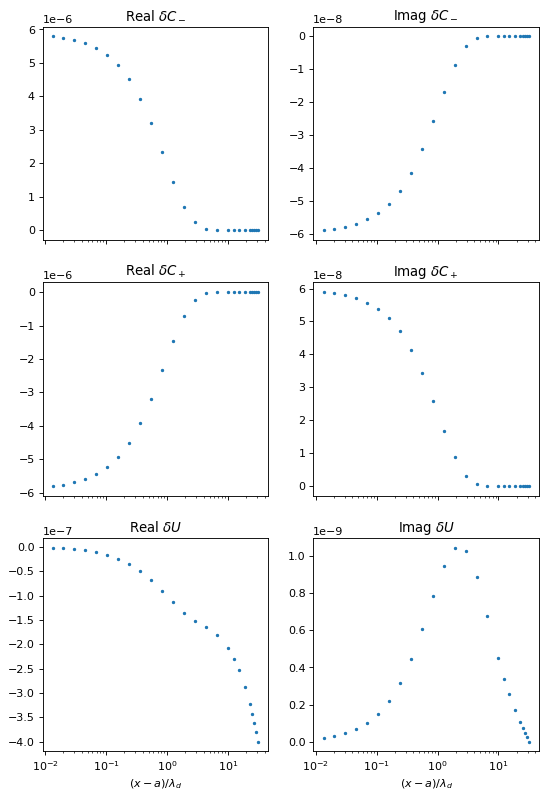

Computing fields and gradients in elements
Time elapsed  0.5029294490814209 sec

Computing fields and gradients in elements
Time elapsed  0.49617815017700195 sec

Computing fields and gradients in elements
Time elapsed  0.5045068264007568 sec



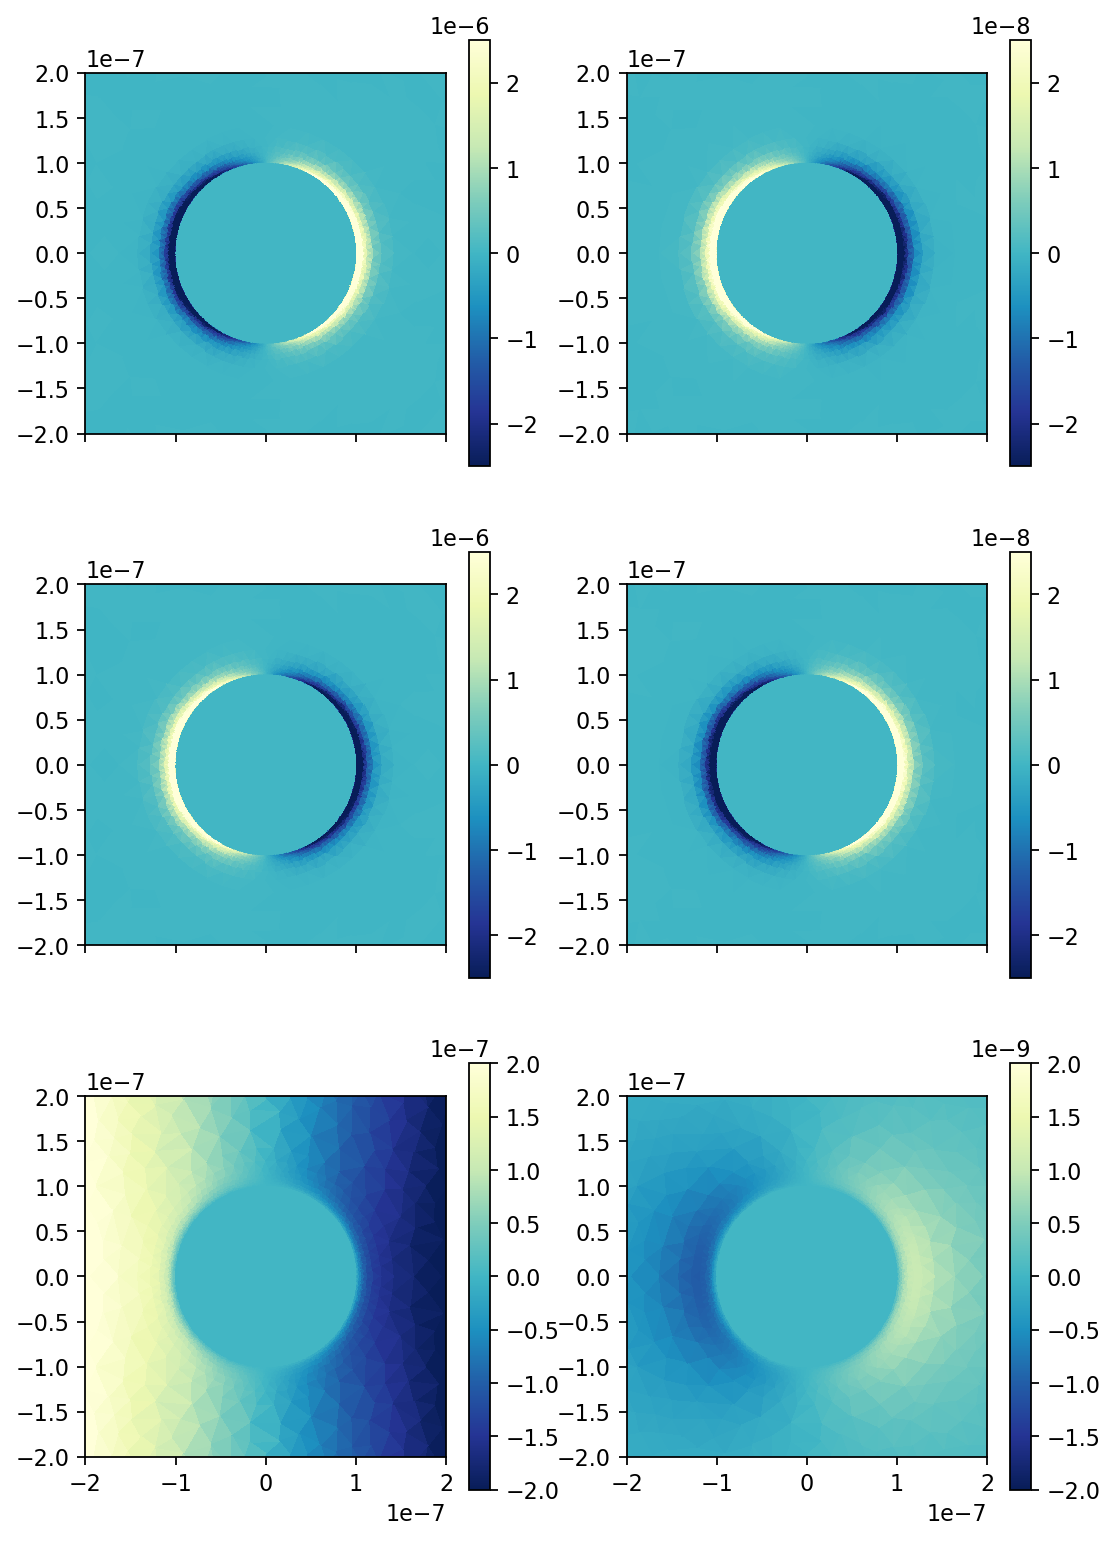

Done


In [137]:
def display_results_real_imag():
    a=0.1e-6
    nodes=mesh['nodes']
    elements=mesh['elements']
    
    #debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    debye_len=np.sqrt(perm0*80*kB*293/2/1**2/echarge**2/kA/1)
    print('DEBYE LENGTH IS: %.2e nm'%(debye_len*1e9))
    
    mask=(mesh['on_survey_lines']&((nodes[:,0])>a))
    fig,ax=plt.subplots(3,2,sharex=True,figsize=(8,4*3),dpi=80)
    axs=ax.flatten()
    titles=['$\delta C_-$','$\delta C_+$','$\delta U$']
    for i in range(3):
        x=(nodes[mask,0]-a)/debye_len
        y=unod[mask,i]
        axs[2*i].plot(x,np.real(y),'.',markersize=4)
        axs[2*i].set_title('Real '+titles[i])
        axs[2*i].set_xscale('log')
        
        axs[2*i+1].plot(x,np.imag(y),'.',markersize=4)
        axs[2*i+1].set_title('Imag '+titles[i])
        axs[2*i+1].set_xscale('log')
    
    axs[4].set_xlabel('$(x-a)/\lambda_d$')
    axs[5].set_xlabel('$(x-a)/\lambda_d$')
    plt.show()
    
    return fig,ax

def display_contour_real_imag():
    a=0.1e-6
    nodes=mesh['nodes']
    elements=mesh['elements']
    
    x=np.r_[nodes[:,0],nodes[:,0]]
    y=np.r_[-nodes[:,1],nodes[:,1]]
    z=np.r_[unod[:,2],unod[:,2]]
    
#     in_active_zones=mesh['in_active_zones']
#     nind=np.unique(elements[in_active_zones,:].flatten())
#     mask=np.ones(len(nodes),dtype=bool)
#     mask[nind]=0
#     print(unod[mask,:])

    vmin=[-2.5e-6,-2.5e-6,-0.2e-6]
    vmax=[2.5e-6,2.5e-6,0.2e-6]
    x=nodes[:,0]
    y=nodes[:,1]
    mids2d=compute_mids2d_elem(nodes,elements,dist_factor=1.0)
    mask=mesh['in_active_zones']
    mask[:]=True

    fig,ax=plt.subplots(3,2,sharex=True,figsize=(8,12),dpi=160)
    axs=ax.flatten()
    for i in range(3):
        u2d=grad2d_elem(nodes,elements,unod[:,i],dist_factor=1.0)[:,0]
        #contourf=ax.tricontourf(x,y,np.real(z),levels=np.linspace(vmin,vmax,101))
        #fig.colorbar(contourf,ax=ax,location='right',ticks=np.linspace(vmin,vmax,11))
        #p=ax.tripcolor(x,y,np.real(z),vmin=vmin,vmax=vmax)
        tpc=axs[2*i].tripcolor(x,y,elements[mask,:],facecolors=np.real(u2d[mask]),
                         edgecolor='none',vmin=vmin[i],vmax=vmax[i],cmap='YlGnBu_r')
        tpc=axs[2*i].tripcolor(x,-y,elements[mask,:],facecolors=np.real(u2d[mask]),
                         edgecolor='none',vmin=vmin[i],vmax=vmax[i],cmap='YlGnBu_r')
        fig.colorbar(tpc,ax=axs[2*i],location='right')
        axs[2*i].set_aspect(1)
        axs[2*i].set_xlim(-2*a,2*a)
        axs[2*i].set_ylim(-2*a,2*a)
        
        tpc=axs[2*i+1].tripcolor(x,y,elements[mask,:],facecolors=np.imag(u2d[mask]),
                         edgecolor='none',vmin=vmin[i]*1e-2,vmax=vmax[i]*1e-2,cmap='YlGnBu_r')
        tpc=axs[2*i+1].tripcolor(x,-y,elements[mask,:],facecolors=np.imag(u2d[mask]),
                         edgecolor='none',vmin=vmin[i]*1e-2,vmax=vmax[i]*1e-2,cmap='YlGnBu_r')
        fig.colorbar(tpc,ax=axs[2*i+1],location='right')
        axs[2*i+1].set_aspect(1)
        axs[2*i+1].set_xlim(-2*a,2*a)
        axs[2*i+1].set_ylim(-2*a,2*a)
        
    plt.show()

    return fig,ax

if __name__=='__main__':
    _,_=display_results_real_imag()
    _,_=display_contour_real_imag()
    print('Done')

# Sphere Model (Thin DL)

## Radial discretization

DEBYE LENGTH IS: 9.63e+00 nm
Ratio of radius to Debye length is: 519.3625269371644
See radial discretization below
[0.00000000e+00 5.00000000e-06 5.00012723e-06 5.00019254e-06
 5.00029138e-06 5.00044095e-06 5.00066730e-06 5.00100985e-06
 5.00152822e-06 5.00231269e-06 5.00349984e-06 5.00529639e-06
 5.00801515e-06 5.01212950e-06 5.01835583e-06 5.02777828e-06
 5.04203749e-06 5.06361625e-06 5.09627187e-06 5.14569033e-06
 5.22047638e-06 5.33365174e-06 5.50492250e-06 5.76411031e-06
 6.15634491e-06 6.74992215e-06 7.64819562e-06 9.00757257e-06
 1.10647476e-05 1.41779157e-05 1.88891413e-05 2.60187425e-05
 3.68081246e-05 5.00000000e-05]
3.926990816987242e-08 1.272324983712166e-10


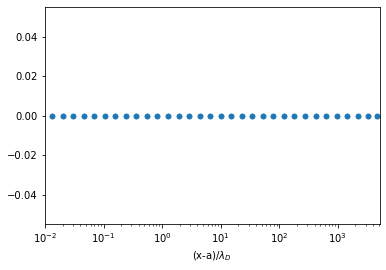

Done


In [35]:
def discretize_grid():
    a=5e-6
    #debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    debye_len=np.sqrt(perm0*80*kB*293/2/1**2/echarge**2/kA/1)
    print('DEBYE LENGTH IS: %.2e nm'%(debye_len*1e9))
    print('Ratio of radius to Debye length is:',a/debye_len)

    rho=np.logspace(np.log10(0.02),1,16)*debye_len+a
    dr=np.diff(np.log10((rho-a)/debye_len))[0]
    rho=np.power(10,np.arange(np.log10(0.02)-dr,1+dr*15,dr))*debye_len+a
    rho=np.r_[0,a,rho,10*a]
    print('See radial discretization below')
    print(rho)
    print(np.pi*a/400,rho[2]-a)
    
    fig,ax=plt.subplots()
    mask=rho>a
    ax.plot((rho[mask]-a)/debye_len,np.zeros_like(rho[mask]),'o',markersize=5)
    ax.set_xscale('log')
    ax.set_xlim(0.01,10*a/debye_len)
    ax.set_xlabel('(x-a)/$\lambda_D$')
    plt.show()
    
    return rho

if __name__=='__main__':
    rho=discretize_grid()
    #print(rho)
    print('Done')

## Mesh generation

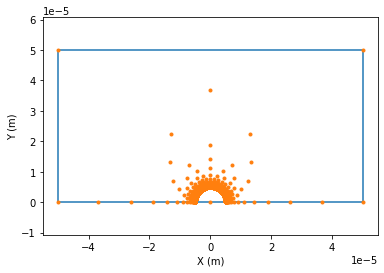

Opening sphere_large.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  15
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  53

Writing sphere_large.1.node.
Writing sphere_large.1.ele.
Writing sphere_large.1.poly.
Writing sphere_large.1.edge.
Writing sphere_large.1.neigh.

Output milliseconds:  101
Total running milliseconds:  181

Statistics:

  Input vertices: 7780
  Input segments: 469
  Input holes: 0

  Mesh vertices: 38010
  Mesh triangles: 75832
  Mesh edges: 113841
  Mesh exterior boundary edges: 186
  Mesh interior boundary edges: 5377
  Mesh subsegments (constrained edges): 5563

Done


In [40]:
import subprocess

def generate_mesh():
    a=5e-6 #radius of the particle
    cpts = np.zeros((0,3)) #coord_x/coord_y/flag of control points
    
    #define the inner sphere points
    #centered at (0,0) with radius a
    dA = max(np.pi*a/400,rho[2]-a)/a
    nA = np.ceil(np.pi/dA)
    ns = nA+1-2
    
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA #half the circle
    x = a*np.cos(phi)+0.0
    y = a*np.sin(phi)+0.0
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the outer corner points
    x = np.r_[np.flipud(-rho),rho[1:]]
    y = np.zeros(len(rho)*2-1)
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*3]] #node flag of 3
    
    x = [10*a,-10*a]
    y = [10*a,10*a]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*4]] #node flag of 4
    
    #define the inner refined points
    for i in range(3,len(rho)-1):
        dA = max(np.pi*a/400,rho[i]-rho[i-1])/a
        nA = np.ceil(np.pi/dA)
        ns = nA+1-2
        
        dA = np.pi/nA
        phi = np.arange(1,ns+1)*dA
        x = rho[i]*np.cos(phi)+0.0
        y = rho[i]*np.sin(phi)+0.0
        cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0

    #define the segments along the inner sphere
    #centered at (0,0) with radius a
    segs = np.zeros((0,3)) #ind_a/ind_b/flag of line segmenets
    dA = max(np.pi*a/400,rho[2]-a)/a
    nA = np.ceil(np.pi/dA)
    ns = nA+1-2
    
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA #half the circle
    x = np.r_[a,a*np.cos(phi)+0.0,-a]
    y = np.r_[0,a*np.sin(phi)+0.0,0]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,1]] #edge flag of 1
    
    #define the segments on the bottom of outer boundary (y of 0)
    x = np.r_[np.flipud(-rho),rho[1:]]
    y = np.zeros(len(rho)*2-1)
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,3]] #edge flag of 3
        
    #define the segmesnts on the right side of the outer boundary (x of 10a)
    x = [10*a,10*a]
    y = [0,10*a]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,4]] #edge flag of 4
    
    #define the segments on the top of the outer boundary (y of 10a)
    x = [10*a,-10*a]
    y = [10*a,10*a]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,5]] #edge flag of 5

    #define the segments on the left of the outer boundary (x of -10a)
    x = [-10*a,-10*a]
    y = [0,10*a]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,6]] #edge flag of 6

    fig,ax=plt.subplots()
    x=cpts[segs[:,:-1].astype(int),0]
    y=cpts[segs[:,:-1].astype(int),1]
    ax.plot(x.T,y.T,'-',color='tab:blue')
    ax.plot(cpts[:,0],cpts[:,1],'.',color='tab:orange')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
#     ax.set_xlim(-50e-9,50e-9)
#     ax.set_ylim(-50e-9,50e-9)
# #     ax.set_xlim(-1e-9,1e-9)
# #     ax.set_ylim(-1e-9,1e-9)
    plt.show()
    
    #build the poly file
    f1 = open('sphere_large.poly','w')
    f1.write(str(len(cpts))+'  2 0 1  #verticies #dimensions  #attributes #boundary markers \n')
    
    #write the vertices
    cnt = 1
    for i in range(len(cpts)):
        f1.write("{0:6.0F} {1:20.5F} {2:20.5F} {3:6.0F}\n".format(cnt,cpts[i,0]*1e6,cpts[i,1]*1e6,cpts[i,2]))
        cnt = cnt+1
    f1.write('\n\n')

    #write the segments
    cnt = 1
    f1.write(str(len(segs))+' 1 #segments, boundary marker\n')
    for i in range(len(segs)):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} {3:6.0F}\n".format(cnt,segs[i,0]+1,segs[i,1]+1,segs[i,2]))
        cnt = cnt+1

    #holes
    f1.write('\n\n0\n\n')
    #f1.write('1 {0:12.6F} {1:12.6F} 1\n\n'.format(0.0,0.5e6*a))

    #area constraints for each of 2 zones
    f1.write('2\n')
    f1.write('1 {0:12.6F} {1:12.6F} 1 {2:12.6F}\n'.format(0.0,0.5e6*a,1e12))
    f1.write('2 {0:12.6F} {1:12.6F} 2 {2:12.6F}\n'.format(0.0,2e6*a,(10e6*a/20)**2))

    f1.write('# triangle -pnq30Aae sphere_large.poly \n')
    f1.close()
    
    return cpts,segs

if __name__=='__main__':
    cpts,segs=generate_mesh()
    process=subprocess.Popen(['triangle -pnq30Aae sphere_large.poly'],shell=True)
    process.wait()

    print('Done')

## Mesh visualization

Reading sphere_large.1.node
Reading sphere_large.1.ele
Reading sphere_large.1.edge
THE NUMBER OF NODES IS: 38010
THE NUMBER OF ELEMENTS IS: 75832
THE NUMBER OF EDGES IS: 113841
THE NUMBER OF ZONES IS: 2
zones [1 2]
edge_flags [0 1 3 4 5 6]



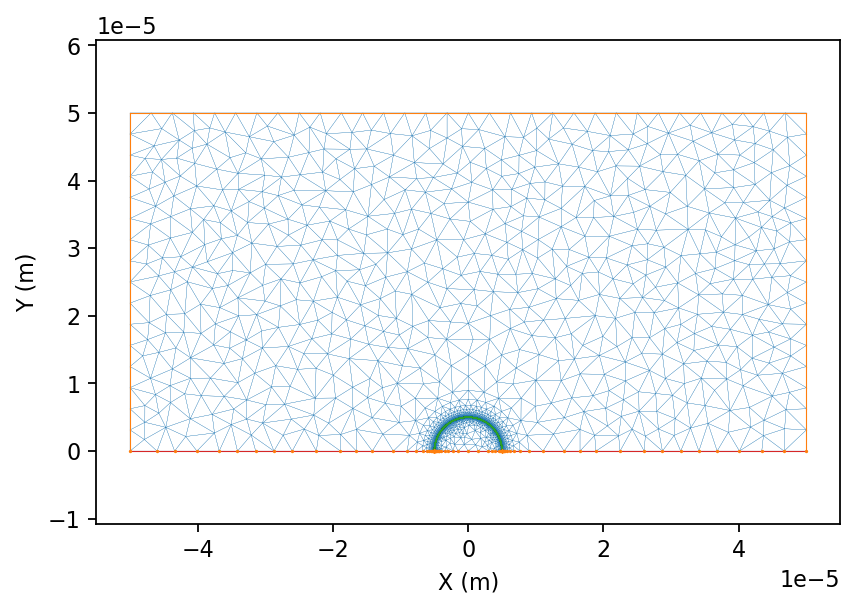

In [41]:
def display_mesh():
    #modify user inputs below
    mesh_prefix='sphere_large'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1
    
    #scale nodes from meter to micro-meter
    nodes=nodes*1e-6
    
    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('THE NUMBER OF ZONES IS: %d'%len(np.unique(zones)))
    print('zones',np.unique(zones))
    print('edge_flags',np.unique(edge_flags))
    print('')
    
    fig,ax=plt.subplots(dpi=160)
    mask=zones>=1 #select zones to display
    x=nodes[elements[:,[0,1,2,0]],0]
    y=nodes[elements[:,[0,1,2,0]],1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.1,color='tab:blue')    
    
    mask=edge_flags==1
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:green')
    
    mask=edge_flags==3
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:red')

    mask=edge_flags>=4
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:orange')

#     mask=node_flags==1
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:green')
#     mask=node_flags==2
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:red')
    mask=node_flags==3
    ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:orange')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
#     ax.set_xlim(5,5.25)
#     ax.set_ylim(0,0.25)
    return fig,ax

if __name__=='__main__':
    fig,ax=display_mesh()
#     nodes=mesh['nodes']
#     elements=mesh['elements']
#     edges=mesh['edges']
#     with_first_kind_bc=mesh['with_first_kind_bc']
#     with_third_kind_bc=mesh['with_third_kind_bc']
#     in_stern=mesh['in_stern']
    
#     nind_bc=np.unique(edges[with_first_kind_bc,:].flatten(order='C'))
#     x=nodes[nind_bc,0]
#     y=nodes[nind_bc,1]
#     ax.plot(x,y,'.',color='tab:orange',markersize=0.5)
    
#     x=nodes[edges[with_third_kind_bc,:],0]
#     y=nodes[edges[with_third_kind_bc,:],1]
#     ax.plot(x.T,y.T,'-',linewidth=0.5,color='tab:red')
    plt.show()


## Mesh properties

In [ ]:
def set_mesh():
    #modify user inputs below
    mesh_prefix='sphere_large'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1

    #scale nodes from meter to micro-meter
    nodes=nodes*1e-6

    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('')

    #define computational elements and boundaries
    in_active_zones=zones>=1 #True for elements used in computation
    #with_first_kind_bc=(edge_flags>=4)|(edge_flags==1) #True for nodes on first kind b.c.
    with_first_kind_bc=edge_flags>=4 #True for nodes on first kind b.c.
    with_third_kind_bc=edge_flags==1 #True for faces on third kind b.c.

    #define electrolyte,solid,stern layer
    in_electrolyte=zones==2
    in_solid=zones==1
    in_stern=edge_flags==1
    
    #more properties
    with_inner_bound=edge_flags==1
    with_outer_bound=edge_flags>=3
    with_top_bound=edge_flags==5
    with_bottom_bound=edge_flags==3
    with_left_bound=edge_flags==6
    with_right_bound=edge_flags==4
    on_survey_lines=(node_flags==3)&(nodes[:,1]<a)
    
    nind_active=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_bc=np.unique(edges[with_first_kind_bc,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_active))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',len(nind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'edges':edges,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern,
          'with_inner_bound':with_inner_bound,
          'with_outer_bound':with_outer_bound,
          'with_top_bound':with_top_bound,
          'with_bottom_bound':with_bottom_bound,
          'with_left_bound':with_left_bound,
          'with_right_bound':with_right_bound,
          'on_survey_lines':on_survey_lines}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=80.0 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    #diffusion_electrolyte=2*1e-9 #diffusion coefficient of water at 20 deg. C is 2*(1e-6*m)^2/(1e-3*s)
    #diffusion_stern=2*1e-10 #diffusion coefficient in Stern layer [m^2/s]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-9 #mobility in Stern layer [m^2/(Vs)]
    sigma_solid=-0.01 #surface charge density in solid [C/m^2]
    
    temp_K=293 #room/ambient temperature [K]
    cinf=1.0 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence
    
    #diffusion coefficient based on Einstein relation
    diffusion_electrolyte=mobility_electrolyte*kB*temp_K/echarge
    diffusion_stern=mobility_stern*kB*temp_K/echarge

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR SOLID IS:',sigma_solid)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_solid':sigma_solid,'debye_len':debye_len,
             'sigma_electrolyte':None,'sigma_stern':None,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}
    
    return physics

if __name__=='__main__':
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

## Static solution

In [ ]:
def set_materials1d(mesh,physics,u1d,freq,case): #modified from set_materials2d
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    c=np.zeros(nedge,dtype=complex)
    alpha_x=np.zeros(nedge,dtype=complex)
    alpha_y=np.zeros(nedge,dtype=complex)
    alpha_z=np.zeros(nedge,dtype=complex)

    beta_x=np.zeros(nedge,dtype=complex)
    beta_y=np.zeros(nedge,dtype=complex)
    beta_z=np.zeros(nedge,dtype=complex)

    gamma_x=np.zeros(nedge,dtype=complex)
    gamma_y=np.zeros(nedge,dtype=complex)
    gamma_z=np.zeros(nedge,dtype=complex)

    a=np.zeros(nedge,dtype=complex)
    f=np.zeros(nedge,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=0 #placeholder; not implemented yet
    anod=0 #placeholder; not implemented yet
    fnod=0 #placeholder; not implemented yet

    c[in_stern]=physics['diffusion_stern']
    gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_y[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_z[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    a[in_stern]=1j

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials
    
def set_materials2d(mesh,physics,u2d,freq,case): #modified from set_materials3d
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']

    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nedge,dtype=complex)
    qs=np.zeros(nedge,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    anod=np.zeros(nnode,dtype=complex)
    fnod=np.zeros(nnode,dtype=complex)

    mids1d=compute_mids1d(mesh['nodes'],mesh['edges'],dist_factor=1.0)
    mids2d=compute_mids2d(mesh['nodes'],mesh['elements'],dist_factor=1.0)
    mids1d[:,:]=1.0
    mids2d[:,:]=1.0
    c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']*mids2d[in_electrolyte,1]
    c[in_solid]=perm0*physics['rel_perm_solid']*mids2d[in_solid,1]
    gs[in_stern]=-physics['sigma_electrolyte']*mids1d[in_stern,1]

    ze=zval*echarge #ion valence times elementary charge
    u2d_scale=ze*u2d[:,0]/kB/temp_K #scaled potential in elements
    a[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u2d_scale)*mids2d[:,1]
    f[:]=-2*ze*kA*cinf*(np.sinh(u2d_scale)-np.cosh(u2d_scale)*u2d_scale)*mids2d[:,1]
    a[in_solid]=0
    f[in_solid]=0

#     elements=mesh['elements']
#     unod_scale=np.zeros(nnode)
#     anod[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(unod_scale)
#     fnod[:]=-2*ze*kA*cinf*(np.sinh(unod_scale)-np.cosh(unod_scale)*unod_scale)
#     nind_solid=np.unique(elements[in_solid].flatten(order='C'))
#     anod[nind_solid]=0
#     fnod[nind_solid]=0

#     edges=mesh['edges']
#     with_inner_bound=mesh['with_inner_bound']
#     nind_bc=np.unique(edges[with_inner_bound,:].flatten(order='C'))
#     snod[nind_bc]=-physics['sigma_electrolyte'] #temporarily use sigma value as potential
#     print('snod',snod[nind_bc])
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials

def build_system(mesh,materials1d,materials2d,case):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode,nnode))
    b=np.zeros(nnode,dtype=complex)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ks2d(mesh,materials2d,K,b,offset=(0,0),nrep=1)
    K,b=set_first_kind_bc2d(mesh,materials2d,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(0,0),nrep=1)

    return K,b

if __name__=='__main__':
    #user input
    #meshfile='sphere_s61_electrolyte.hdf5'
    #physfile='sphere_s61_electrolyte.hdf5'    
    srvfile='not_exit.srv'
    dist_factor=1

    #setup mesh and material properties
    #mesh=import_mesh(meshfile)
    #physics=import_physics(physfile)
    ratio=1.0
    physics['sigma_electrolyte']=-(1-ratio)*physics['sigma_solid']
    physics['sigma_stern']=-ratio*physics['sigma_solid']
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',physics['sigma_electrolyte'])
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',physics['sigma_stern'])
    print('')
    
    #initialize mesh variables
    nodes=mesh['nodes']
    elements=mesh['elements']
    edges=mesh['edges']

    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_active=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(edges[in_stern,:].flatten(order='C'))
    
    #run iterative simulation
    u1d=np.zeros((len(edges),3))
    u2d=np.zeros((len(elements),3))
    unod=np.zeros(len(nodes),dtype=complex)
    unod_1=np.zeros(len(nodes),dtype=complex)
    materials1d=set_materials1d(mesh,physics,u1d,freq=None,case=1)
    materials2d=set_materials2d(mesh,physics,u2d,freq=None,case=1)
    mesh_scale=scale_mesh(mesh,dist_factor)
    sigma_max=np.max(np.abs(materials2d['gs']))
    sigma_min=np.minimum(0.002e-2,sigma_max)
    if sigma_max>0:
        materials2d['gs']=materials2d['gs']/sigma_max*sigma_min
    for i in range(20):
        print('==================== ITERATION #',i+1,' ====================')
        print('')
        print('sigma_min',sigma_min,'sigma_max',sigma_max)
        materials1d_scale=scale_materials(materials1d,dist_factor)
        materials2d_scale=scale_materials(materials2d,dist_factor)
        K,b=build_system(mesh_scale,materials1d_scale,materials2d_scale,case=1)
        unod_1[:]=unod
        unod[:]=solve_unod(K/perm0,b/perm0)
        if np.linalg.norm(unod)>0:
            rel_error=np.linalg.norm(unod-unod_1)/np.linalg.norm(unod)
        else:
            rel_error=0.0
        print('Relative error is',rel_error)
        if (sigma_min==sigma_max)&(rel_error<0.05):
            print('Solution is converged')
            print('')
            break
        print('')
        u2d=grad2d(nodes,elements,unod,dist_factor=dist_factor)
        materials2d=set_materials2d(mesh,physics,u2d,freq=None,case=1)
        sigma_min=np.minimum(sigma_min*5,sigma_max)
        if sigma_max>0:
            materials2d['gs']=materials2d['gs']/sigma_max*sigma_min
        

    #unod=reshape_unod(unod,nrep=1)
    #output=output_unod(nodes,unod[:,0],srvfile)

    np.save('sphere_s62',unod)
    print('Done')

# Slab Model Benchmark

## User input

In [3]:
if __name__=='__main__':
    #user input of simulation types
    nrep=1 #number of ion types plus 1 (ions plus potential)
    mode=2 #1 for basic problem; 2 for coupled problem
    
    #user input of slab model geometry
    radius_air=500e-6 #radius of the air
    height_air=1000e-6 #height of the air
    radius_water=2e-6 #radius of thin water film
    height_water=2e-9 #thickness of thin water film
    radius_solid=2e-6 #radius of the solid
    height_solid=2e-6 #height of the solid
    radius_tip=10e-9 #radius of cantilever tip
    offset_tip=20e-9 #offset between cantilever tip and solid-liquid interface
    radius_cone=20e-6 #radius of catilever cone
    height_cone=20e-6 #height of cantilever cone
    radius_arm=40e-6 #radius of cantilever arm
    height_arm=5e-6 #height of cantilever arm

    #user input of physical parameters
    temp_K=293.0 #ambient temperature in [Kelvin]
    cinf=1.0 #ion concentration at infinity
    ncharge=1.0 #ion valence or charge number (z)
    qcharge=ncharge*echarge #electric charge (q) in [Coulombs]
    
    rel_perm_a=80.0 #relative permittivity of electrolyte
    rel_perm_i=4.5 #relative permittivity of solid
    perm_a=perm0*rel_perm_a #permittivity of electrolyte [F/m]
    perm_i=perm0*rel_perm_i #permittivity of solid [F/m]
    sig_i=-0.01 #surface charge density of solid surface[C/m^2]
    
    mob_a=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mob_s=5e-11 #mobility in Stern layer [m^2/(Vs)]
    diff_a=mob_a*kB*temp_K/qcharge #diffusion coefficient based on Einstein relation
    diff_s=mob_s*kB*temp_K/qcharge #diffusion coefficient based on Einstein relation

    #calculate Debye length and distance scaling factor
    debye_len=np.sqrt(perm_a*kB*temp_K/2/qcharge**2/kA/cinf)    
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('AMBIENT TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',ncharge)
    print('')
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_a)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_i)
    print('SURFACE CHARGE DENSITY OF SOLID SURFACCE IS:',sig_i)
    print('')
    print('ION MOBILITY IN ELECTROLYTE IS: %.2e'%mob_a)
    print('ION MOBILITY IN STERN LAYER IS: %.2e'%mob_s)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS: %.2e'%diff_a)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS: %.2e'%diff_s)
    print('')

    print('Done')

DEBYE LENGTH IS: 9.63e-09 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+08

AMBIENT TEMPERATURE IS: 293.0
ION COCENTRATION AT INFINITY IS: 1.0
ION VALENCE IS: 1.0

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 80.0
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
SURFACE CHARGE DENSITY OF SOLID SURFACCE IS: -0.01

ION MOBILITY IN ELECTROLYTE IS: 5.00e-08
ION MOBILITY IN STERN LAYER IS: 5.00e-11
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 1.26e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.26e-12

Done


## Radial discretization <a id="4.1"></a>

min(np.diff(rho) 9.88e-02 nm
height_water 2.00e-09 nm


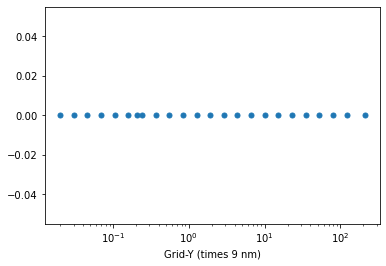

Done


In [6]:
def discretize_grid():
    #obtain fine grid next to the solid-liquid interface
    #use 16 points between 0.02*debye_len and 10*debye_len
    #reduce debye_len if thin water film presents
    #debye_len=min(debye_len,1e-9)
    rho=np.logspace(np.log10(0.02),1,16)*debye_len
    dr=np.diff(np.log10(rho/debye_len))[0]
    print('min(np.diff(rho) %.2e nm'%(min(np.diff(rho))*1e9))
    print('height_water %.2e nm'%height_water)
    
    #use the logarithmic interval above to discretize the entire space
    #which extends to radius_solid for this slab example
    n=2
    while 1:
        rho=np.power(10,np.arange(np.log10(0.02),1+dr*n,dr))*debye_len
        if rho[-1]<radius_solid:
            n=n+1
        else:
            break
    
    #adjust the starting and ending points in the discretization
    rho=np.r_[0,rho[:-2],max(radius_solid,height_solid)]
    
    #insert water-air interface into the discretization
    mask=rho<height_water
    rho=np.r_[rho[mask],height_water,rho[~mask]]
    #ind=np.argmin((rho-height_water)**2)
    #rho[ind]=height_water
    
    #display and check the discretization
    fig,ax=plt.subplots()
    mask=rho>0
    ax.plot(rho[mask]/debye_len,np.zeros_like(rho[mask]),'o',markersize=5)
    ax.set_xscale('log')
    ax.set_xlabel('Grid-Y (times %d nm)'%(debye_len*1e9))
    #ax.set_xlim(0.01,20)
    plt.show()
    return rho

if __name__=='__main__':
    rho=discretize_grid()
    print('Done')

## Mesh generation <a id="4.3"></a>

Lowermost boundary: edge flag 1
Rightmost boundary: edge flag 2
Uppermost boundary: edge flag 3
Axis of symmetry: edge flag 4
Bottom of solid: edge flag 5
Right of solid: edge flag 6
Solid-liquid interface: edge flag 7
Right of water: edge flag 8
Air-water interface: edge flag 9
Tip surface: edge flag 10
Cone surface: edge flag 11
Arm surface: edge flag 12

Opening slab_2d.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  15

Writing slab_2d.1.node.
Writing slab_2d.1.ele.
Writing slab_2d.1.poly.
Writing slab_2d.1.edge.
Writing slab_2d.1.neigh.

Output milliseconds:  68
Total running milliseconds:  96

Statistics:

  Input vertices: 129
  Input segments: 112
  Input holes: 0

  Mesh vertices: 5896
  Mesh

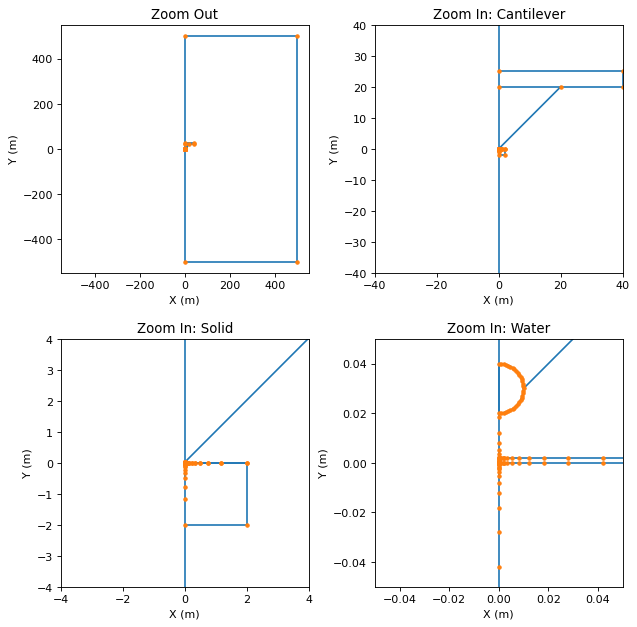

Done


In [7]:
def build_mesh():
    #X is the axis of symmetry
    #Y is the longitudinal axis
    cpts = np.zeros((0,3)) #coord_x/coord_y/flag of control points
    segs = np.zeros((0,3)) #ind_a/ind_b/flag of line segmenets
    
    #**************************************************************************
    #==========================================================================
    #--------------------------------------------------------------------------
    #define the lowermost, rightmost, and topmost boundary points
    x = np.r_[0,radius_air,radius_air,0]
    y = np.r_[-height_air/2,-height_air/2,height_air/2,height_air/2]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
        
    #define the leftmost boundary points (on the axis of symmetry)
    #skip points at two ends
    mask = (rho>0)&(rho<offset_tip)
    y = np.r_[-np.flipud(rho),rho[mask],offset_tip,offset_tip+2*radius_tip,
              offset_tip+2*radius_tip+height_cone,
              offset_tip+2*radius_tip+height_cone+height_arm]
    x = np.zeros(len(y))
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #--------------------------------------------------------------------------
    #define the top, right, and bottom edge points of the solid
    #skip edge points on the axis of symmetry
    x = np.r_[rho[1:-1],radius_solid,radius_solid]
    y = np.r_[0*rho[1:-1],0,-height_solid]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0
    
    #--------------------------------------------------------------------------
    #define the top edge points of the water
    #skip edge points on the axis of symmetry
    x = np.r_[rho[1:-1],radius_water]
    y = np.ones(len(x))*height_water
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0
    
    #--------------------------------------------------------------------------
    #define the edge points on the tip surface
    #skip edge points on the axis of symmetry
    nA = 32
    ns = nA+1-2
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA-np.pi/2 #half the circle
    x = radius_tip*np.cos(phi)+0.0
    y = radius_tip*np.sin(phi)+offset_tip+radius_tip
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0
    
    #--------------------------------------------------------------------------
    #define the edge points on the cone surface
    x = np.r_[radius_cone]
    y = np.r_[height_cone]+offset_tip+2*radius_tip
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0
    
    #--------------------------------------------------------------------------
    #define inner control points along the cantilever
    x = np.r_[radius_arm,radius_arm]
    y = np.r_[0,height_arm]+offset_tip+2*radius_tip+height_cone
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0
    
    #**************************************************************************
    #==========================================================================
    #--------------------------------------------------------------------------
    #define the segments on the lowermost boundary
    x = np.r_[0,radius_air]
    y = np.r_[-height_air/2,-height_air/2]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,1]] #edge flag of 1
    print('Lowermost boundary: edge flag 1')
    
    #define the segments on the rightmost boundary
    x = np.r_[radius_air,radius_air]
    y = np.r_[-height_air/2,height_air/2]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,2]] #edge flag of 2
    print('Rightmost boundary: edge flag 2')
    
    #define the segments on the topmost boundary
    x = np.r_[0,radius_air]
    y = np.r_[height_air/2,height_air/2]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,3]] #edge flag of 3
    print('Uppermost boundary: edge flag 3')
    
    #define the segmesnts on the leftmost boundary (axis of symmetry)
    mask = (rho>0)&(rho<offset_tip)
    y = np.r_[-height_air/2,-np.flipud(rho),rho[mask],offset_tip,
              offset_tip+2*radius_tip,offset_tip+2*radius_tip+height_cone,
              offset_tip+2*radius_tip+height_cone+height_arm,height_air/2]
    x = np.zeros(len(y))
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,4]] #edge flag of 4
    print('Axis of symmetry: edge flag 4')
        
    #--------------------------------------------------------------------------
    #define the segments on the lower edge of the solid
    x = np.r_[0,radius_solid]
    y = np.r_[-height_solid,-height_solid]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,5]] #edge flag of 5
    print('Bottom of solid: edge flag 5')
    
    #define the segments on the right edge of the solid
    x = np.r_[radius_solid,radius_solid]
    y = np.r_[-height_solid,0]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,6]] #edge flag of 6
    print('Right of solid: edge flag 6')

    #define the segments on the top edge of the solid (solid-liquid interface)
    x = np.r_[rho[:-1],radius_solid]
    y = np.zeros((len(x)))
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,7]] #edge flag of 7
    print('Solid-liquid interface: edge flag 7')
    
    #--------------------------------------------------------------------------
    #define the segments on the right edge of the water
    x = np.r_[radius_water,radius_water]
    y = np.r_[0,height_water]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,8]] #edge flag of 8
    print('Right of water: edge flag 8')
    
    #define the segments on the top edge of the water
    x = np.r_[0,radius_water]
    y = np.r_[height_water,height_water]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,9]] #edge flag of 9
    print('Air-water interface: edge flag 9')
    
    #--------------------------------------------------------------------------
    #define the segments along the tip surface
    nA = 32
    ns = nA+1-2
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA-np.pi/2 #half the circle
    x = np.r_[0,radius_tip*np.cos(phi)+0.0,0,0]
    y = np.r_[0,radius_tip*np.sin(phi)+radius_tip,2*radius_tip,0]+offset_tip
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,10]] #edge flag of 10
    print('Tip surface: edge flag 10')
    
    #--------------------------------------------------------------------------
    #define the top and right segments along the cone surface
    x = np.r_[0,radius_cone,radius_tip]
    y = np.r_[height_cone,height_cone,-radius_tip]+offset_tip+2*radius_tip
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,11]] #edge flag of 11
    print('Cone surface: edge flag 11')
    
    #--------------------------------------------------------------------------
    #define the segments along the remaining cantilever surface
    x = np.r_[0,radius_arm,radius_arm,radius_cone]
    y = np.r_[height_arm,height_arm,0,0]+offset_tip+2*radius_tip+height_cone
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,12]] #edge flag of 12
    print('Arm surface: edge flag 12')
    print('')
        
    #**************************************************************************
    #==========================================================================
    #--------------------------------------------------------------------------
    #define markers for holes and zones
    holes = np.zeros((0,2))
    zones = np.zeros((0,3))
    x = np.r_[0,0,0,0,0,0]+radius_tip/2 #solid,liquid,tip,cone,arm,air
    y = np.r_[-height_solid/2,height_water/2,offset_tip+radius_tip,
              offset_tip+2*radius_tip+height_cone/2,
              offset_tip+2*radius_tip+height_cone+height_arm/2,
              height_air/4]
    area = np.r_[1,1,1,100,100,900]
    zones = np.r_[zones,np.c_[x,y,area]]
    
    #build the poly file
    f1 = open('slab_2d.poly','w')
    f1.write(str(len(cpts))+'  2 0 1  #verticies #dimensions  #attributes #boundary markers \n')
    
    #write the vertices
    cnt = 1    
    for i in range(len(cpts)):
        f1.write("{0:6.0F} {1:20.5F} {2:20.5F} {3:6.0F}\n".format(cnt,cpts[i,0]*1e6,cpts[i,1]*1e6,cpts[i,2]))
        cnt = cnt+1
    f1.write('\n\n')

    #write the segments
    cnt = 1
    f1.write(str(len(segs))+' 1 #segments, boundary marker\n')
    for i in range(len(segs)):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} {3:6.0F}\n".format(cnt,segs[i,0]+1,segs[i,1]+1,segs[i,2]))
        cnt = cnt+1
        
    #holes
    f1.write('\n\n%d\n'%(len(holes)))
    for i in range(len(holes)):
        x = holes[i,0]
        y = holes[i,1]
        f1.write('{0:12.0F} {1:12.6F} {2:12.6F} 1\n'.format(i+1,x*1e6,y*1e6))
    f1.write('\n\n')

    #zones
    f1.write('\n\n%d\n'%(len(zones)))
    for i in range(len(zones)):
        x = zones[i,0]
        y = zones[i,1]
        area = zones[i,2]
        f1.write('{0:12.0F} {1:12.6F} {2:12.6F} {3:12.0F} {4:12.6F}\n'.format(i+1,x*1e6,y*1e6,i+1,area))
    
    f1.write('# triangle -pnq30Aae slab_2d.poly \n')
    f1.close()
    
    #**************************************************************************
    #==========================================================================
    #--------------------------------------------------------------------------
    #build mesh
    process=subprocess.Popen(['/home/zhuy359/projects/E4D/third_party/triangle/triangle -pnq30Aae slab_2d.poly'],shell=True)
    process.wait()
    
    #**************************************************************************
    #==========================================================================
    #--------------------------------------------------------------------------
    disp_factor = 1e6
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    x=cpts[segs[:,:-1].astype(int),0]
    y=cpts[segs[:,:-1].astype(int),1]
    axs[0].plot(x.T*disp_factor,y.T*disp_factor,'-',color='tab:blue')
    axs[0].plot(cpts[:,0]*disp_factor,cpts[:,1]*disp_factor,'.',color='tab:orange')
    axs[0].set_xlabel('X (m)')
    axs[0].set_ylabel('Y (m)')
    axs[0].set_aspect('equal')
    axs[0].set_xlim(-radius_air*1.1*disp_factor,radius_air*1.1*disp_factor)
    axs[0].set_ylim(-radius_air*1.1*disp_factor,radius_air*1.1*disp_factor)
    axs[0].set_title('Zoom Out')
    
    axs[1].plot(x.T*disp_factor,y.T*disp_factor,'-',color='tab:blue')
    axs[1].plot(cpts[:,0]*disp_factor,cpts[:,1]*disp_factor,'.',color='tab:orange')
    axs[1].set_xlabel('X (m)')
    axs[1].set_ylabel('Y (m)')
    axs[1].set_aspect('equal')
    axs[1].set_xlim(-height_cone*2*disp_factor,height_cone*2*disp_factor)
    axs[1].set_ylim(-height_cone*2*disp_factor,height_cone*2*disp_factor)
    axs[1].set_title('Zoom In: Cantilever')
    
    axs[2].plot(x.T*disp_factor,y.T*disp_factor,'-',color='tab:blue')
    axs[2].plot(cpts[:,0]*disp_factor,cpts[:,1]*disp_factor,'.',color='tab:orange')
    axs[2].set_xlabel('X (m)')
    axs[2].set_ylabel('Y (m)')
    axs[2].set_aspect('equal')
    axs[2].set_xlim(-height_solid*2*disp_factor,height_solid*2*disp_factor)
    axs[2].set_ylim(-height_solid*2*disp_factor,height_solid*2*disp_factor)
    axs[2].set_title('Zoom In: Solid')
    
    axs[3].plot(x.T*disp_factor,y.T*disp_factor,'-',color='tab:blue')
    axs[3].plot(cpts[:,0]*disp_factor,cpts[:,1]*disp_factor,'.',color='tab:orange')
    axs[3].set_xlabel('X (m)')
    axs[3].set_ylabel('Y (m)')
    axs[3].set_aspect('equal')
    axs[3].set_xlim(-height_water*25*disp_factor,height_water*25*disp_factor)
    axs[3].set_ylim(-height_water*25*disp_factor,height_water*25*disp_factor)
    axs[3].set_title('Zoom In: Water')
    
    plt.tight_layout()
    plt.show()
    return cpts,segs

if __name__=='__main__':
    cpts,segs=build_mesh()
    print('Done')

## Mesh Visualization <a id="4.4"></a>

Reading slab_2d.1.node
Reading slab_2d.1.ele
Reading slab_2d.1.edge
THE NUMBER OF NODES IS: 5896
THE NUMBER OF ELEMENTS IS: 11630
THE NUMBER OF EDGES IS: 17525
node_flags [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
elem_flags [1 2 3 4 5 6]
edge_flags [ 0  1  2  3  4  5  6  7  8  9 10 11 12]



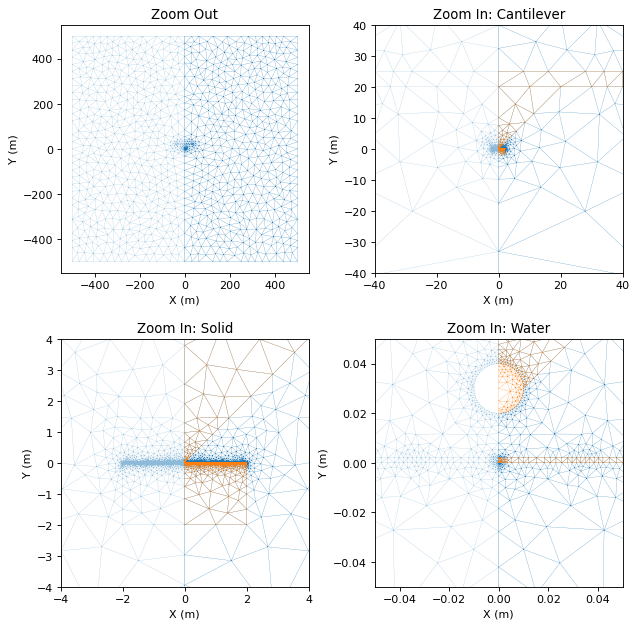

Done


In [85]:
def display_mesh():    
    #modify user inputs below
    mesh_prefix='slab_2d'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    elem_flags=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1
    
    #scale nodes from meter to micro-meter
    nodes=nodes*1e-6
    
    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('node_flags',np.unique(node_flags))
    print('elem_flags',np.unique(elem_flags))
    print('edge_flags',np.unique(edge_flags))
    print('')
    
    #**************************************************************************
    #==========================================================================
    #--------------------------------------------------------------------------
    #display mesh
    disp_factor=1e6
    x=nodes[:,0]*disp_factor
    y=nodes[:,1]*disp_factor
    
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    
    mask=(elem_flags<=2)|(elem_flags>=4)
    axs[0].triplot(x,y,elements[mask,:],linewidth=0.2,color='tab:blue')
    axs[0].triplot(-x,y,elements[mask,:],linewidth=0.2,color='tab:blue',alpha=0.5)
    axs[0].set_xlabel('X (m)')
    axs[0].set_ylabel('Y (m)')
    axs[0].set_aspect('equal')
    axs[0].set_xlim(-radius_air*1.1*disp_factor,radius_air*1.1*disp_factor)
    axs[0].set_ylim(-radius_air*1.1*disp_factor,radius_air*1.1*disp_factor)
    axs[0].set_title('Zoom Out')
    
    mask=(elem_flags<=2)|(elem_flags>=4)
    axs[1].triplot(x,y,elements[mask,:],linewidth=0.2,color='tab:blue')
    axs[1].triplot(-x,y,elements[mask,:],linewidth=0.2,color='tab:blue',alpha=0.5)
    mask=(elem_flags>=1)&(elem_flags<=5)
    axs[1].triplot(x,y,elements[mask,:],linewidth=0.2,color='tab:orange')
    axs[1].set_xlabel('X (m)')
    axs[1].set_ylabel('Y (m)')
    axs[1].set_aspect('equal')
    axs[1].set_xlim(-height_cone*2*disp_factor,height_cone*2*disp_factor)
    axs[1].set_ylim(-height_cone*2*disp_factor,height_cone*2*disp_factor)
    axs[1].set_title('Zoom In: Cantilever')
    
    mask=(elem_flags<=2)|(elem_flags>=4)
    axs[2].triplot(x,y,elements[mask,:],linewidth=0.2,color='tab:blue')
    axs[2].triplot(-x,y,elements[mask,:],linewidth=0.2,color='tab:blue',alpha=0.5)
    mask=(elem_flags>=1)&(elem_flags<=5)
    axs[2].triplot(x,y,elements[mask,:],linewidth=0.2,color='tab:orange')
    axs[2].set_xlabel('X (m)')
    axs[2].set_ylabel('Y (m)')
    axs[2].set_aspect('equal')
    axs[2].set_xlim(-height_solid*2*disp_factor,height_solid*2*disp_factor)
    axs[2].set_ylim(-height_solid*2*disp_factor,height_solid*2*disp_factor)
    axs[2].set_title('Zoom In: Solid')
    
    mask=(elem_flags<=2)|(elem_flags>=4)
    axs[3].triplot(x,y,elements[mask,:],linewidth=0.2,color='tab:blue')
    axs[3].triplot(-x,y,elements[mask,:],linewidth=0.2,color='tab:blue',alpha=0.5)
    mask=(elem_flags>=2)&(elem_flags<=5)
    axs[3].triplot(x,y,elements[mask,:],linewidth=0.2,color='tab:orange')
    axs[3].set_xlabel('X (m)')
    axs[3].set_ylabel('Y (m)')
    axs[3].set_aspect('equal')
    axs[3].set_xlim(-height_water*25*disp_factor,height_water*25*disp_factor)
    axs[3].set_ylim(-height_water*25*disp_factor,height_water*25*disp_factor)
    axs[3].set_title('Zoom In: Water')
    
    plt.tight_layout()
    plt.show()
    return

if __name__=='__main__':
    display_mesh()
    print('Done')

## Full space solution

### Mesh properties

In [4]:
def set_mesh():
    #modify user inputs below
    mesh_prefix='slab_2d'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    elem_flags=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1
    
    #scale nodes from meter to micro-meter
    nodes=nodes*1e-6
    
    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('node_flags',np.unique(node_flags))
    print('elem_flags',np.unique(elem_flags))
    print('edge_flags',np.unique(edge_flags))
    print('')
    
    #**************************************************************************
    #==========================================================================
    #--------------------------------------------------------------------------
    #define electrolyte,solid,stern layer
    # in_air=elem_flags>=4 #shape of (nelem,)
    # in_electrolyte=elem_flags==2 #shape of (nelem,)
    # in_solid=elem_flags==1 #shape of (nelem,)
    # in_stern=edge_flags==7 #shape of (nedge,)
    in_air=(elem_flags<=2)|(elem_flags>=4)
    in_electrolyte=elem_flags==-1 #all false
    in_solid=elem_flags==-1 #all false
    in_stern=edge_flags==7 #all false
    
    #define computational zones
    in_active_zones=(elem_flags<=2)|(elem_flags>=4) #shape of (nelem,)
    
    #define edges with first kind b.c.
    #with_first_kind_bc=np.zeros((nedge,1),dtype=bool) #nrep of 1
    #with_first_kind_bc[:,0]=((edge_flags>=1)&(edge_flags<=3))|(edge_flags==10)
    with_first_kind_bc=((edge_flags>=1)&(edge_flags<=3))|(edge_flags==10)
    
    #define edges with third kind b.c.
    #with_third_kind_bc=np.zeros((nedge,1),dtype=bool) #nrep of 3
    #with_third_kind_bc[:,0]=edge_flags==-1 #all false
    with_third_kind_bc=edge_flags==-1 #all false
    
    #define nodes on first kind b.c.
    #on_first_kind_bc=np.zeros((nnode,1),dtype=bool)
    on_first_kind_bc=node_flags==-1 #all false
    #nind=np.argmin((nodes[:,0]-radius_water)**2+(nodes[:,1]-0.0)**2)
    #on_first_kind_bc[nind]=True
    
    #define nodes on third kind b.c.
    #on_third_kind_bc=np.zeros((nnode,1),dtype=bool) #placeholder
    on_third_kind_bc=node_flags==-1 #placeholder
    
    #save mesh properties into a dict
    mesh={'elements':elements,'elem_flags':elem_flags,
          'nodes':nodes,'node_flags':node_flags,
          'edges':edges,'edge_flags':edge_flags,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'on_first_kind_bc':on_first_kind_bc,
          'on_third_kind_bc':on_third_kind_bc,
          'in_air':in_air,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=80.0 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-11 #mobility in Stern layer [m^2/(Vs)]
    sigma_solid=-0.01 #surface charge density in solid [C/m^2]
    
    temp_K=293 #room/ambient temperature [K]
    cinf=1.0 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence
    
    #diffusion coefficient based on Einstein relation
    diffusion_electrolyte=mobility_electrolyte*kB*temp_K/echarge
    diffusion_stern=mobility_stern*kB*temp_K/echarge

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR SOLID IS:',sigma_solid)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_solid':sigma_solid,'debye_len':debye_len,
             'sigma_electrolyte':None,'sigma_stern':None,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}
    
    return physics

if __name__=='__main__':
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

Reading slab_2d.1.node
Reading slab_2d.1.ele
Reading slab_2d.1.edge
THE NUMBER OF NODES IS: 5896
THE NUMBER OF ELEMENTS IS: 11630
THE NUMBER OF EDGES IS: 17525
node_flags [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
elem_flags [1 2 3 4 5 6]
edge_flags [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.63e-09 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+08

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 80.0
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 1.2628995006242197e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.2628995006242196e-12
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-11
SURFACE CHARGE DENSITY FOR SOLID IS: -0.01
TEMPERATURE IS: 293
ION COCENTRATION AT INFINITY IS: 1.0
ION VALENCE IS: 1

Done


### Material properties

In [ ]:
def display_materials():
    
    return

if __name__=='__main__':
    display_materials()
    print('Done')

### Run simulation <a id="4.6"></a>

In [5]:
def set_materials1d(mesh,physics,u1d,freq,s0,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])
    
    in_air=mesh['in_air']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros(nedge,dtype=complex)
    alpha_x=np.zeros(nedge,dtype=complex)
    alpha_y=np.zeros(nedge,dtype=complex)
    alpha_z=np.zeros(nedge,dtype=complex)

    beta_x=np.zeros(nedge,dtype=complex)
    beta_y=np.zeros(nedge,dtype=complex)
    beta_z=np.zeros(nedge,dtype=complex)

    gamma_x=np.zeros(nedge,dtype=complex)
    gamma_y=np.zeros(nedge,dtype=complex)
    gamma_z=np.zeros(nedge,dtype=complex)

    a=np.zeros(nedge,dtype=complex)
    f=np.zeros(nedge,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=np.zeros(nnode,dtype=complex) #placeholder; not implemented yet
    anod=np.zeros(nnode,dtype=complex) #placeholder; not implemented yet
    fnod=np.zeros(nnode,dtype=complex) #placeholder; not implemented yet

    nodes=mesh['nodes']
    edges=mesh['edges']
    #mids2d_edge local and global are the same in this example
    #need to verify from the initial coordinate conversion formula
    #to make sure if local or global mids2d_edge should be used
    mids2d_edge=compute_mids2d_edge(nodes,edges,dist_factor=1.0,local=False)
    
    #shall below be mids2d_edge or mids1d_edge; need to be verified
    #c[in_stern]=physics['diffusion_stern']*mids2d_edge[in_stern,0]
    #gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']*mids2d_edge[in_stern,0] #coupled coefficient
    #a[in_stern]=1j*freq*2*np.pi*mids2d_edge[in_stern,0]
    a[in_stern]=1.0
    
    #on_first_kind_bc=mesh['on_first_kind_bc']
    #snod[on_first_kind_bc]=0.0
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def set_materials2d(mesh,physics,u2d,freq,s0,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])
    
    in_active_zones=mesh['in_active_zones']
    in_air=mesh['in_air']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    
    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nedge,dtype=complex)
    qs=np.zeros(nedge,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    anod=np.zeros(nnode,dtype=complex)
    fnod=np.zeros(nnode,dtype=complex)
    
    nodes=mesh['nodes']
    elements=mesh['elements']
    edges=mesh['edges']
    mids2d_edge=compute_mids2d_edge(nodes,edges,dist_factor=1.0,local=False)
    mids2d_elem=compute_mids2d_elem(nodes,elements,dist_factor=1.0)
    
    #c[in_air]=perm0*mids2d_elem[in_air,0]
    #c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']*mids2d_elem[in_electrolyte,0]
    #c[in_solid]=perm0*physics['rel_perm_solid']*mids2d_elem[in_solid,0]
    #gs[in_stern]=1.0*mids2d_edge[in_stern,0] #coupled coefficient; sign to be verified
    #c[in_active_zones]=perm0*mids2d_elem[in_active_zones,0]
    c[in_air]=perm0*mids2d_elem[in_air,0]
    
    #with_equipotential_bc=mesh['with_equipotential_bc']
    #nind_bc=np.unique(edges[with_equipotential_bc,:].flatten(order='C'))
    #snod[nind_bc]=s0 #Volts
    mask=mesh['node_flags']<=3
    snod[mask]=0 #Volts
    mask=mesh['node_flags']==10
    snod[mask]=10 #Volts
        
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def build_system(mesh,materials1d,materials2d,case):
    nnode=len(mesh['nodes'])
    mats2d_zero_gs=copy.deepcopy(materials2d)
    mats2d_zero_gs['gs'][:]=0

    mats1d_zero_gamma=copy.deepcopy(materials1d)
    mats1d_zero_gamma['gamma_x'][:]=0
    mats1d_zero_gamma['gamma_y'][:]=0

    K=csr_matrix((nnode*2,nnode*2),dtype=complex)
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke2d_elem(mesh,mats2d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 element
    K,b=assemble_Ks2d_edge(mesh,mats2d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 edge
    K,b=assemble_Ke1d_edge(mesh,mats1d_zero_gamma,K,b,offset=(nnode,nnode),nrep=1) #K22 element

    K,b=assemble_Ks2d1d(mesh,materials2d,K,b,offset=(0,nnode),nrep=1) #coupled term of K12
    K,b=assemble_Ke1d2d(mesh,materials1d,K,b,offset=(nnode,0),nrep=1) #coupled term of K12

    K,b=set_first_kind_bc2d_edge(mesh,materials2d,K,b,offset=(0,0),nrep=1) #K11 1st kind b.c.
    K,b=set_first_kind_bc2d_node(mesh,materials1d,K,b,offset=(nnode,nnode),nrep=1) #K22 1st kind b.c.
    K,b=set_inactive_nodes2d_elem(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d_edge(mesh,K,b,offset=(nnode,nnode),nrep=1)
    
    return K,b

if __name__=='__main__':
    #user input
    savedir='/home/zhuy359/projects/sip/slab3'
    srvfile='not_exit.srv'
    dist_factor=1.0 #not tested yet
    freq=[0]
    ratio=1.0
    
    #do not modify anything below this line
    physics['sigma_electrolyte']=-(1-ratio)*physics['sigma_solid']
    physics['sigma_stern']=-ratio*physics['sigma_solid']
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',physics['sigma_electrolyte'])
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',physics['sigma_stern'])
            
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
    
    for i in range(len(freq)):
        print('==================== Frequency %d/%d'%(i+1,len(freq)),' ====================')
        u1d=np.zeros((len(mesh['edges']),3))
        u2d=np.zeros((len(mesh['elements']),3))
        materials1d=set_materials1d(mesh,physics,u1d,freq=freq[i],s0=1.0,case=5)
        materials2d=set_materials2d(mesh,physics,u2d,freq=freq[i],s0=1.0,case=5)
        mesh_scale=scale_mesh(mesh,dist_factor)
        materials1d_scale=scale_materials(materials1d,dist_factor)
        materials2d_scale=scale_materials(materials2d,dist_factor)
        K,b=build_system(mesh_scale,materials1d_scale,materials2d_scale,case=5)
        unod=solve_unod(K,b)

        unod=reshape_unod(unod,coupled=True,nrep=1)
        #output=output_unod(nodes,unod[:,0],srvfile)
        np.save(savedir+'/freq_%.2e'%freq[i],unod)
    print('Done')

SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: 0.0
SURFACE CHARGE DENSITY FOR STERN LAYER IS: 0.01
==================== Frequency 1/1  ====================
TEST CASE IS: 5
Setting material properties in Stern layer

TEST CASE IS: 5
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Assembling the system of equations
Time elapsed  2.169400930404663 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.005267620086669922 sec

Assembling the system of equations
Time elapsed  0.13893914222717285 sec

Implementing coupled terms of the system of equations (1/2)
Time elapsed  0.0076596736907958984 sec

Implementing coupled terms of the system of equations (2/2)
Time elapsed  0.15948104858398438 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  1.523422479629516

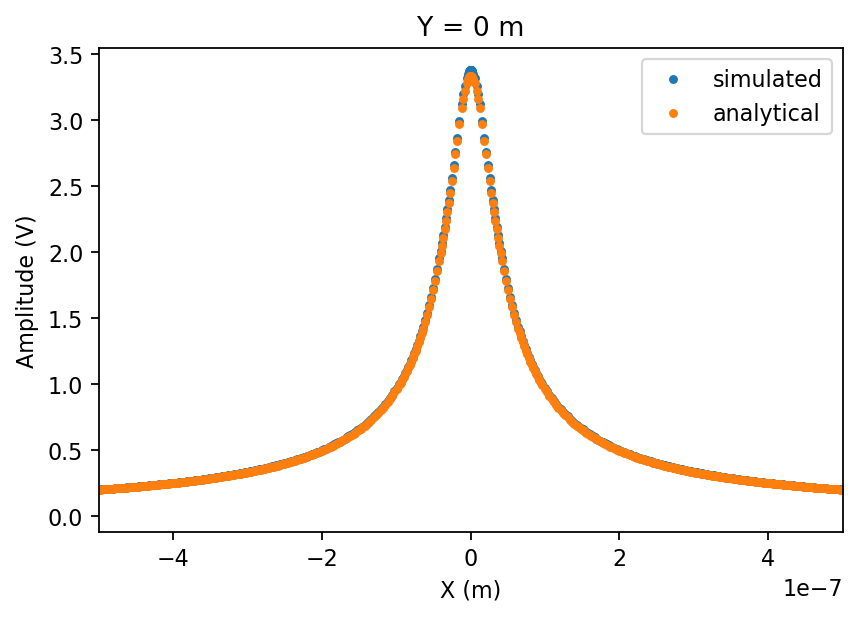

Done


In [6]:
def display_results_real_imag():
    nodes=mesh['nodes']
    elements=mesh['elements']
    edges=mesh['edges']
    in_active_zones=mesh['in_active_zones']
    nind_zones=np.unique(elements[in_active_zones,:].flatten())
    in_stern=mesh['in_stern']
    nind_stern=np.unique(edges[in_stern,:].flatten(order='C'))
    
    #analytical solutoin u=s*a/(r-r0)
    dist=np.sqrt((nodes[:,0]-0.0)**2+(nodes[:,1]-radius_tip-offset_tip)**2)
    ansol=10*radius_tip/dist
    
    xlims=np.r_[-0.2e-6,0.2e-6]*2.5
    fig,ax=plt.subplots(dpi=160)
    ax.plot(nodes[nind_stern,0],np.real(unod[nind_stern,0]),'.',color='tab:blue')
    ax.plot(nodes[nind_stern,0],ansol[nind_stern],'.',color='tab:orange')
    
    ax.plot(-nodes[nind_stern,0],np.real(unod[nind_stern,0]),'.',color='tab:blue')
    ax.plot(-nodes[nind_stern,0],ansol[nind_stern],'.',color='tab:orange')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Amplitude (V)')
    ax.set_xlim(xlims)
    ax.set_title('Y = 0 m')
    ax.legend(['simulated','analytical'])
    
    plt.savefig('slab_1.png',bbox_inches='tight')
    plt.show()
    return

if __name__=='__main__':
    display_results_real_imag()
    print('Done')

## Half space solution

# Survey Backup (FFT)

## Survey setup <a id="4.2"></a>

In [ ]:
# Remarks
# Discrete (non-continuous) signals in one domain 
# correspond to periodic signals in the other domain
# 
# Discrete/periodic x in [0, N) or [0, T) implying x[N] = x[0] or x[1*T] = x[0*T]
# only x[0], x[1], ..., x[N-2], x[N-1] are required in DFT/FFT as principle values
#
# Similar for discrete/periodic X in [0, N) or [0, 2*Pi*F)
#
# Time domain sampling interval dT
# corresponds to periodic X in [0, N) or [0, 2*Pi/dT)
#
# Frequency domain sampling interval dF
# corresponds to periodic x in [0, N) or [0, 1/dF)
#
# Given N and T in time domain
# dT = T/N, dF = 1/T, F = N/T, (F = N*dF = N/T)
#
# Given N and dT in time domain
# T = dT*N, dF = 1/(dT*N), F = 1/dT, (F = N*dF = 1/dT)
#
# Given N and F in frequency domain
# dF = F/N, dT = 1/F, T = N/F, (T = N*dT = N/F)
# 
# Given N and dF in frequency domain
# F = N*dF, dT = 1/(N*dF), T = 1/dF, (T = N*dT = 1/dF)
#
# Real signal x in time domain corresponds to  
# conjugate symmetric singal in frequency domain 
# X[k]= X[N-k].conj()

Done


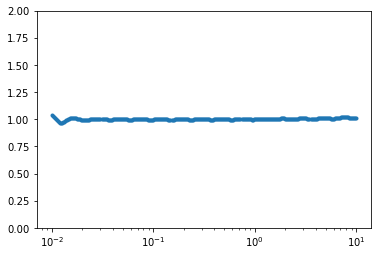

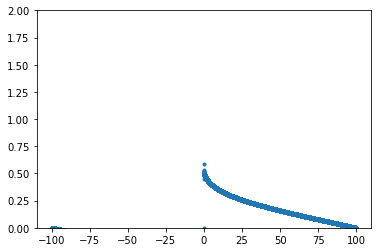

In [8]:
def get_signal_fftlog():
    signal = 1
    
    targ={}
    targ['add_dec'] = [-2,1] #additional decades [left, right] (default: [-2, 1])
    targ['pts_per_dec'] = 10 #sampels per decade (default: 10)
    targ['q'] = -0.6 #exponent of power law bias (default: 0); -1 <= q <= 1
    
    # If switch-off is required, use cosine, else sine
    if signal >= 0:
        targ['mu'] = 0.5
    else:
        targ['mu'] = -0.5

    time = np.logspace(-2, 1, 301)  # Desired times (s)
    minf = np.log10(1/time.max())+targ['add_dec'][0]
    maxf = np.log10(1/time.min())+targ['add_dec'][1]
    n = np.int64(maxf-minf)*targ['pts_per_dec']
    
    # Initialize FFTLog, get required parameters
    freq, tcalc, dlnr, kr, rk = get_fftlog_input(
            minf, maxf, n, targ['q'], targ['mu'])
    
    targ['tcalc'] = tcalc
    targ['dlnr'] = dlnr
    targ['kr'] = kr
    targ['rk'] = rk

    if signal in [-1, 1]:
        # Divide by signal/(2j*pi*f) to obtain step response
        fact = signal/(2j*np.pi*freq).ravel()
    else:
        fact = np.ones(len(freq))
    
    return time,freq,fact,targ

def get_signal_fft():
    signal = 1
    
    targ={}
    targ['dfreq'] = 0.005 #Linear step-size of frequencies (default: 0.002)
    targ['nfreq'] = 2**20 #Number of frequencies (default: 2048)
    targ['ntot'] = 2**20 #Total number for FFT; difference between nfreq and ntot
        #is padded with zeroes. This number is ideally a power of 2, e.g.
        #2048 or 4096 (default: nfreq)
    targ['pts_per_dec']= 10 #points per decade (default: None)
    
    #Padding can sometimes improve the result, not always. The default
    #samples from 0.002 Hz - 4.096 Hz. If pts_per_dec is set to an
    #integer, calculated frequencies are logarithmically spaced with the
    #given number per decade, and then interpolated to yield the required
    #frequencies for the FFT.
    
    # Get required frequencies
    if targ['pts_per_dec']:  # Space actually calc. freqs logarithmically.
        start = np.log10(targ['dfreq'])
        stop = np.log10(targ['nfreq']*targ['dfreq'])
        freq = np.logspace(
                start, stop, int((stop-start)*targ['pts_per_dec'] + 1))
    else:
        freq = np.arange(1, targ['nfreq']+1)*targ['dfreq']
    
    ntot = targ['nfreq']
    dt = 1/(2*ntot*targ['dfreq'])
    time = np.linspace(-ntot, ntot-1, 2*ntot)*dt

    if signal in [-1, 1]:
        # Divide by signal/(2j*pi*f) to obtain step response
        fact = signal/(2j*np.pi*freq).ravel()
    else:
        fact = np.ones(len(freq))
    
    return time,freq,fact,targ

if __name__=='__main__':
    time,freq,fact,ftarg = get_signal_fftlog()
    out_fftlog = fourier_fftlog(fact, time, freq, ftarg)[0]*2/np.pi
    
    fig,ax=plt.subplots()
    ax.plot(time,out_fftlog,'.')
    ax.set_ylim(0,2)
    ax.set_xscale('log')
        
    time,freq,fact,ftarg = get_signal_fft()
    out_fft = fourier_fft(fact, time, freq, ftarg)[0]*2/np.pi
    
    fig,ax=plt.subplots()
    ax.plot(time,out_fft,'.')
    ax.set_ylim(0,2)
    print('Done')

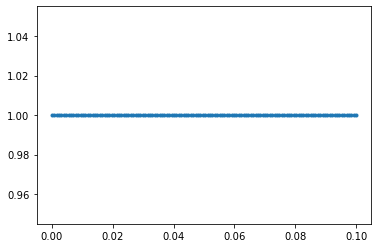

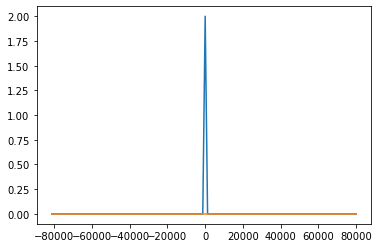

In [147]:
time = np.linspace(0,0.1,128)
dt = time[1]-time[0]
nt = len(time)
freq_shift = np.linspace(-nt/2,nt/2-1,nt)*(1/dt)
freq = np.fft.fftshift(freq_shift)

fact_td = np.zeros_like(time)
# fact_td[time>=0.05] = 1
# fact_td[time<0.05] = 1
# # fact_td[101] = 1
fact_td[:] = 1

fig, ax = plt.subplots()
ax.plot(time,fact_td,'.')
fact_fd=np.fft.fft(fact_td)

# fact_td = np.zeros(len(fact_td),dtype=complex)
# freq = np.fft.fftshift(freq_shift)
# fact_fd[freq==0] = np.pi
# fact_fd[freq!=0] = 1/(2j*np.pi*freq[freq!=0])
# fig, ax = plt.subplots()
# ax.plot(time,np.fft.ifft(fact_fd),'.')
fig, ax = plt.subplots()
ax.plot(freq_shift,np.fft.fftshift(np.real(fact_fd))/(nt//2),'-')
ax.plot(freq_shift,np.fft.fftshift(np.imag(fact_fd))/(nt//2),'-')
# print(np.imag(fact_fd))

plt.show()

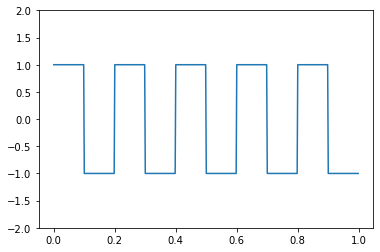

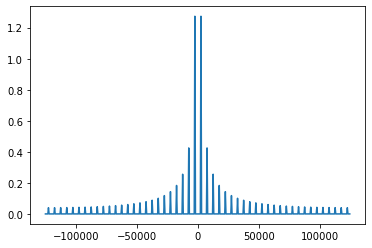

In [121]:
from scipy import signal
import matplotlib.pyplot as plt
# scipy.signal.square(t, duty=0.5)
# Return a periodic square-wave waveform.
# The square wave has a period 2*pi, 
# has value +1 from 0 to 2*pi*duty 
# and -1 from 2*pi*duty to 2*pi. 
# duty must be in the interval [0,1].

# A 5 Hz waveform sampled at 500 Hz for 1 second:
t = np.linspace(0, 1, 500, endpoint=False)
plt.subplots()
plt.plot(t, signal.square(2 * np.pi * 5 * t))
# t = np.linspace(0, 1, 500, endpoint=False)
# plt.plot(t, signal.square(t))
plt.ylim(-2, 2)

time = t
dt = time[1]-time[0]
nt = len(time)
freq_shift = np.linspace(-nt/2,nt/2-1,nt)*(1/dt)
X = fftpack.fft(signal.square(2 * np.pi * 5 * t))
plt.subplots()
plt.plot(freq_shift,np.fft.fftshift(np.abs(X))/(nt//2),'-')
# print(X)

(-1.5, 1.5)

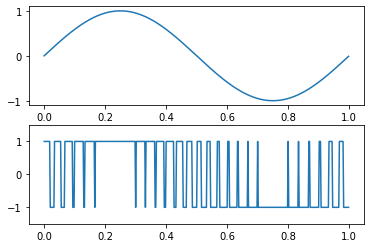

In [79]:
plt.figure()
sig = np.sin(2 * np.pi * t)
pwm = signal.square(2 * np.pi * 30 * t, duty=(sig + 1)/2)
plt.subplot(2, 1, 1)
plt.plot(t, sig)
plt.subplot(2, 1, 2)
plt.plot(t, pwm)
plt.ylim(-1.5, 1.5)


Done


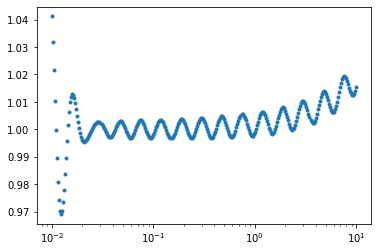

In [7]:
def get_signal_fftlog():
    signal = 1
    
    targ={}
    targ['add_dec'] = [-2,1] #additional decades [left, right] (default: [-2, 1])
    targ['pts_per_dec'] = 10 #sampels per decade (default: 10)
    targ['q'] = -0.6 #exponent of power law bias (default: 0); -1 <= q <= 1
    
    # If switch-off is required, use cosine, else sine
    if signal >= 0:
        targ['mu'] = 0.5
    else:
        targ['mu'] = -0.5

    time = np.logspace(-2, 1, 301)  # Desired times (s)
    minf = np.log10(1/time.max())+targ['add_dec'][0]
    maxf = np.log10(1/time.min())+targ['add_dec'][1]
    n = np.int64(maxf-minf)*targ['pts_per_dec']
    
    # Initialize FFTLog, get required parameters
    freq, tcalc, dlnr, kr, rk = get_fftlog_input(
            minf, maxf, n, targ['q'], targ['mu'])
    
    targ['tcalc'] = tcalc
    targ['dlnr'] = dlnr
    targ['kr'] = kr
    targ['rk'] = rk

    if signal in [-1, 1]:
        # Divide by signal/(2j*pi*f) to obtain step response
        fact = signal/(2j*np.pi*freq).ravel()
    else:
        fact = np.ones(len(freq))
    
    return time,freq,fact,targ

def get_signal_fft():
    signal = 0
    
    targ={}
    targ['dfreq'] = 0.005 #Linear step-size of frequencies (default: 0.002)
    targ['nfreq'] = 2**20 #Number of frequencies (default: 2048)
    targ['ntot'] = 2**20 #Total number for FFT; difference between nfreq and ntot
        #is padded with zeroes. This number is ideally a power of 2, e.g.
        #2048 or 4096 (default: nfreq)
    targ['pts_per_dec']= 10 #points per decade (default: None)
    
    #Padding can sometimes improve the result, not always. The default
    #samples from 0.002 Hz - 4.096 Hz. If pts_per_dec is set to an
    #integer, calculated frequencies are logarithmically spaced with the
    #given number per decade, and then interpolated to yield the required
    #frequencies for the FFT.
    
    # Get required frequencies
    if targ['pts_per_dec']:  # Space actually calc. freqs logarithmically.
        start = np.log10(targ['dfreq'])
        stop = np.log10(targ['nfreq']*targ['dfreq'])
        freq = np.logspace(
                start, stop, int((stop-start)*targ['pts_per_dec'] + 1))
    else:
        freq = np.arange(1, targ['nfreq']+1)*targ['dfreq']
    
    ntot = targ['nfreq']
    dt = 1/(2*ntot*targ['dfreq'])
    time = np.linspace(-ntot, ntot-1, 2*ntot)*dt

    if signal in [-1, 1]:
        # Divide by signal/(2j*pi*f) to obtain step response
        fact = signal/(2j*np.pi*freq).ravel()
    else:
        fact = np.ones(len(freq))
    
    return time,freq,fact,targ

if __name__=='__main__':
    time,freq,fact,ftarg = get_signal_fftlog()
    out = fourier_fftlog(fact, time, freq, ftarg)[0]*2/np.pi
    fig,ax=plt.subplots()
    ax.plot(time,out,'.')
    ax.set_xscale('log')
    print('Done')

In [ ]:
def set_signal(sr = 100):
    # sampling rate
    # sr = 100

    # sampling interval
    ts = 1.0 / sr
    t = np.arange(0, 1, ts)
    x = np.zeros_like(t)
    x[(t > 0.3) & (t <= 0.7)] = 1
    
#     #test waveform
#     freq = 3.
#     x = 3*np.sin(2*np.pi*freq*t)

#     freq = 4
#     x += np.sin(2*np.pi*freq*t)

#     freq = 7
#     x += 0.5* np.sin(2*np.pi*freq*t)
    
    # fourier transform
    X = fft(x)
    N = len(X)
    n = np.arange(N)
    T = N / sr
    freq = n / T
    
    n_oneside = N//2
    # get the one side frequency
    f_oneside = freq[1:n_oneside+1]

    # normalize the amplitude
    X_oneside =X[1:n_oneside+1]/n_oneside
    
#     # Carry out FFT
#     dfreq=0.1
#     nfreq=2**10
#     freq=np.arange(1,nfreq+1)*dfreq
    
    fEM = X_oneside
    ntot = n_oneside
    dfreq = 1
    ifftEM = np.fft.ifft(np.r_[fEM[::-1], 0, fEM[:].conj()]).real
    stEM = 2*ntot*np.fft.fftshift(ifftEM*dfreq, 0)
    dt = 1/(2*ntot*dfreq)
    time = np.linspace(-ntot, ntot, 2*ntot+1)*dt
    fig,ax=plt.subplots()
    ax.plot(time[time>=0],stEM[time>=0])
    ax.plot(t,x)
    
    ifftEM = np.fft.ifft(np.r_[fEM[1:], 0, fEM[::-1].conj()]).real
    stEM = 2*ntot*np.fft.fftshift(ifftEM*dfreq, 0)
    dt = 1/(2*ntot*dfreq)
    time = np.linspace(-ntot, ntot-1, 2*ntot)
    print('ntot',ntot,'n_oneside',n_oneside)
    print('time')
    print(time)
    print('fftshift')
    print(np.fft.fftshift(np.arange(ntot*2)))
    time = np.linspace(-ntot, ntot-1, 2*ntot)*dt
    fig,ax=plt.subplots()
    ax.plot(time[time>=0],stEM[time>=0])
    ax.plot(t,x)

    
    plt.figure(figsize = (8, 8))
    plt.subplot(221)

    plt.stem(freq, np.abs(X), 'b', markerfmt=' ', basefmt='-b')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')

    print('N')
    print(len(X))
    tmp = np.fft.fftshift(ifft(np.fft.fftshift(X)))
    plt.subplot(222)
    plt.plot(t, tmp, 'r', drawstyle='steps-post')
    plt.plot(t, x, 'o', color='grey', alpha=300e-3)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    
    plt.subplot(223)
    plt.stem(np.arange(N)-n_oneside,np.fft.fftshift(np.abs(X))/n_oneside, \
             'b', markerfmt=' ', basefmt='-b')
    plt.xlabel('Index N')
    plt.ylabel('DFT Amplitude |X(freq)|')
    
    plt.subplot(224)
    plt.stem(np.arange(N)-n_oneside,np.fft.fftshift(np.abs(X))/n_oneside, \
             'b', markerfmt=' ', basefmt='-b')
    plt.xlabel('Index N')
    plt.ylabel('DFT Amplitude |X(freq)|')
    plt.xlim(-10, 10)
    plt.show()
    
    signal={'freq':f_oneside,'field_fd':X_oneside,'time':t,'field_td':x}
    
    return signal

if __name__=='__main__':
    signal = set_signal(sr = 128+1)
#     time_scale=1e-2
#     print('min(frequencies) besides 0')
#     print('%.2e'%(min(signal['freq'][1:])/time_scale))
#     print('max(frequencies) besides 0')
#     print('%.2e'%(max(signal['freq'][1:])/time_scale))
#     print('# of frequencies besides 0')
#     print(len(signal['freq'][1:]))
#     print('')
#     print(signal['freq'])
#     print(np.fft.fftshift(signal['freq']))
    print('Done')

In [ ]:
def set_signal():
    nfreq=2**10
    dfreq=1e3
    f_oneside=np.arange(1,nfreq)*dfreq
    X_oneside=1/(2j*np.pi*f_oneside)
    X_oneside[:]=0
    find=np.argmin((f_oneside-1e5)**2)
    X_oneside[find]=1
    print(f_oneside[find])
    freq=np.r_[0,f_oneside[:],0,f_oneside[::-1]]
    X=np.r_[0,X_oneside[:],0,X_oneside[::-1].conj()]
    
    ntot=nfreq
    dt=1/(2*ntot*dfreq)
    time=np.linspace(-ntot,ntot-1,2*ntot)*dt
#     x=2*ntot*np.fft.ifft(X)
#     x_shift=np.fft.fftshift(x*dfreq,0)
#     x_shift=x_shift/2/dfreq
    x=ntot*np.fft.ifft(X)
    x_shift=np.fft.fftshift(x,0)
    
    fig,ax=plt.subplots()
    ax.plot(time,np.real(x_shift),'-')
    ax.plot(time,np.imag(x_shift),'.',color='grey',alpha=0.3)
    ax.plot(time,np.cos(2*np.pi*1e5*time))
    ax.set_xlim(0,2e-5)
    
#     t=np.a
    
    signal={'freq'}
    return signal


if __name__=='__main__':
    signal = set_signal()
    print('Done')

# FFT Test

In [ ]:
# Remarks from scipy.fftpack.fft
# This function is most efficient when n is a power of two, 
# and least efficient when n is prime.
# 
# Note that if x is real-valued, then A[j] == A[n-j].conjugate(). 
# If x is real-valued and n is even, then A[n/2] is real.

# Remarks from scipy.fft.fft
# If x is a 1d array, then the fft is equivalent to
# y[k] = np.sum(x * np.exp(-2j * np.pi * k * np.arange(n)/n))
# The frequency term f=k/n is found at y[k]. 
# At y[n/2] we reach the Nyquist frequency and wrap around to the 
# negative-frequency terms. So, for an 8-point transform, the 
# frequencies of the result are [0, 1, 2, 3, -4, -3, -2, -1]. 
# To rearrange the fft output so that the zero-frequency component is centered, 
# like [-4, -3, -2, -1, 0, 1, 2, 3], use fftshift.

# https://dsp.stackexchange.com/questions/22842/why-remove-energy-at-nyquist-before-ifft
# so if you're doing audio, i would likely set both the Nyquist and 
# the DC components to zero and also insure the complex-conjugate 
# symmetry with the other bins before iFFT. just to make sure that, 
# within rounding error, the imaginary part of your result is zero 
# (the result is purely real) and that you have an unambiguous 
# magnitude and phase for every non-zero component.


## Impulse function

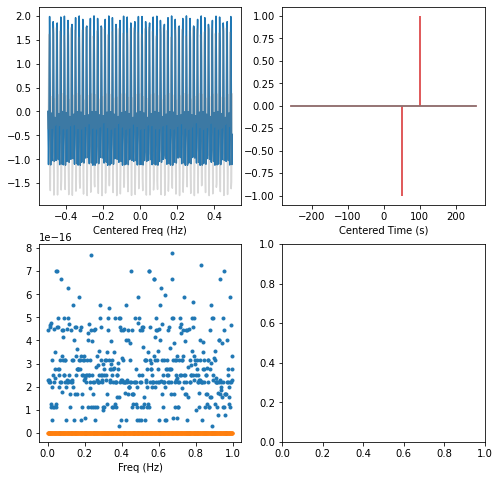

Done


In [117]:
def test_impulse():
    # frequency domain sampling
    dfreq = 1/(2*2**8)
    n_oneside = 2**8
    freq = np.arange(n_oneside*2)*dfreq
    freq_shift = np.linspace(-n_oneside,n_oneside-1,n_oneside*2)*dfreq
    
    # time domain sampling
    dt = 1/(dfreq*n_oneside*2)
    time = np.arange(n_oneside*2)*dt
    time_shift = np.linspace(-n_oneside,n_oneside-1,n_oneside*2)*dt
    
    # impulse function in frequency domain
    rads_oneside = 2*np.pi*np.arange(n_oneside)/(n_oneside*2) #relative angular freq
    X_oneside = np.zeros(n_oneside,dtype=complex)
    X_oneside[:] = 1*np.exp(-1j*rads_oneside[:]*(100)) #time delay of 100 points
    X_oneside[:] += -1*np.exp(-1j*rads_oneside[:]*(50)) #time delay of 50 points
    X = np.r_[X_oneside,0,X_oneside[:0:-1].conj()] #play with 0 or 1 padding in the middle
    X[n_oneside] = 1*np.exp(-1j*np.pi*(-100)) # must be real
    
    # zero-out 0 and N//2 components
    # will not affect x much except at two ends
    # for large number of sampling points
    X[0] = 0
    X[n_oneside] = 0
    
#     # The following yields the same time signal (Why?)
#     X[:] = X[:]/(ntot*2)
#     X[:] = X[:].conj()
#     print(X[0]*ntot*2,X[n_oneside]*ntot*2)
#     print(X[n_oneside-1]*ntot*2)
#     print(np.exp(-1j*rads_oneside[-1]*(10)))
    
    x = np.fft.ifft(X)
# #     print('x')
# #     print(x)

#     fig,ax=plt.subplots()
#     ax.plot(np.real(x))
    
#     # debug with true signal
#     x[:] = 0
#     x[10] = 1
#     X = np.fft.ifft(x)
#     print(X[0]*ntot*2,X[n_oneside]*ntot*2)
#     print(X[n_oneside-1]*ntot*2)
#     print(np.exp(-1j*rads_oneside[-1]*(10)))
    
#     ax.plot(np.real(x))
    
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    axs = ax.flatten()
    axs[0].plot(freq_shift,np.fft.fftshift(np.real(X)),'-')
    axs[0].plot(freq_shift,np.fft.fftshift(np.imag(X)),'-',color='grey',alpha=0.3)
    axs[0].set_xlabel('Centered Freq (Hz)')
    
    axs[1].stem(time_shift,np.fft.fftshift(np.real(x)),'tab:red',markerfmt=' ',basefmt='tab:red')
    axs[1].stem(time_shift,np.fft.fftshift(np.imag(x)),'grey',markerfmt=' ',basefmt='grey')
    axs[1].set_xlabel('Centered Time (s)')
    
    axs[2].plot(freq,np.real(np.abs(np.fft.fft(x)-X)),'.')
    axs[2].plot(freq,np.imag(np.abs(np.fft.fft(x)-X)),'.')
    #axs[2].set_ylim(0,1)
    axs[2].set_xlabel('Freq (Hz)')
    
    plt.show()
    return

if __name__=='__main__':
    test_impulse()
    print('Done')

## Sine wave

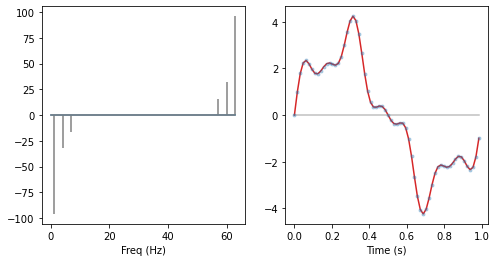

Done


In [112]:
def test_sine():
    # frequency domain sampling
    dfreq = 1
    n_oneside = 2**5
    freq = np.arange(n_oneside*2)*dfreq
    freq_shift = np.linspace(-n_oneside,n_oneside-1,n_oneside*2)*dfreq
    
    # time domain sampling
    dt = 1/(dfreq*n_oneside*2)
    time = np.arange(n_oneside*2)*dt
    time_shift = np.linspace(-n_oneside,n_oneside-1,n_oneside*2)*dt
    
    # sine wave components in frequency domain
    X_oneside = np.zeros(n_oneside,dtype=complex)
    find = np.argmin((freq-1)**2)
    X_oneside[find] = -3j*n_oneside
    find = np.argmin((freq-4)**2)
    X_oneside[find] = -1j*n_oneside
    find = np.argmin((freq-7)**2)
    X_oneside[find] = -0.5j*n_oneside
    
    X = np.r_[X_oneside,0,X_oneside[:0:-1].conj()]
    x = np.fft.ifft(X)
    
    #expected signal
    data = 3*np.sin(2*np.pi*1*time)
    data += np.sin(2*np.pi*4*time)
    data += 0.5*np.sin(2*np.pi*7*time)
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    axs = ax.flatten()
    axs[0].stem(freq,np.real(X),'tab:blue',markerfmt=' ',basefmt='tab:blue')
    axs[0].stem(freq,np.imag(X),'grey',markerfmt=' ',basefmt='grey')
    axs[0].set_xlabel('Freq (Hz)')
    
    axs[1].plot(time,np.real(x),'-',color='tab:red')
    axs[1].plot(time,np.imag(x),'-',color='grey',alpha=0.5)
    axs[1].plot(time,data,'.',color='tab:blue',alpha=0.3)
    axs[1].set_xlabel('Time (s)')
    #print(x)
    plt.show()
    return

if __name__=='__main__':
    test_sine()
    print('Done')

## Step function

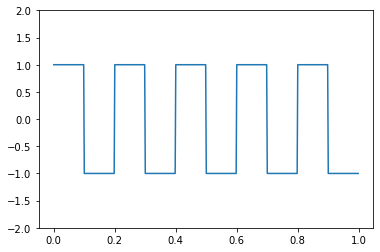

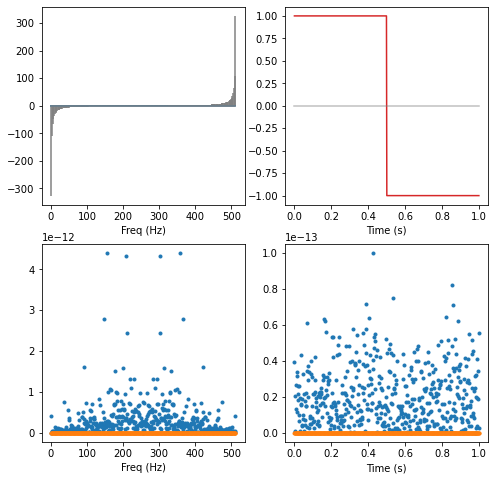

Done


In [257]:
from scipy import signal
import matplotlib.pyplot as plt

# A 5 Hz waveform sampled at 500 Hz for 1 second
t = np.linspace(0, 1, 500, endpoint=False)
plt.plot(t, signal.square(2 * np.pi * 5 * t))
plt.ylim(-2, 2)

def test_step():
    # frequency domain sampling
    dfreq = 1
    n_oneside = 2**8
    freq = np.arange(n_oneside*2)*dfreq
    freq_shift = np.linspace(-n_oneside,n_oneside-1,n_oneside*2)*dfreq
    
    # time domain sampling
    dt = 1/(dfreq*n_oneside*2)
    time = np.arange(n_oneside*2)*dt
    time_shift = np.linspace(-n_oneside,n_oneside-1,n_oneside*2)*dt
    
    # square wave
    source = signal.square(2*np.pi*1*time) # 2 cycles in [0,T)
#     source = (source+1)/2
#     plt.subplots()
#     plt.plot(time,source,'-')
    
    # impulse function in frequency domain
    rads_oneside = 2*np.pi*np.arange(n_oneside)/(n_oneside*2) #relative angular freq
    freq_oneside = np.arange(n_oneside)*dfreq
    X_oneside = np.zeros(n_oneside,dtype=complex)
    
    #refer to the formula of impulse function
    for n in range(0,n_oneside*2):
        X_oneside[1:] += source[n]*np.exp(-1j*rads_oneside[1:]*n)
        
#     X_oneside[:] = 0
#     X_oneside[1:] = np.exp(1/(1j*freq_oneside[1:]))
#     X_oneside[1:] = 1/np.exp(1j*rads_oneside[1:])
    X = np.r_[X_oneside,0,X_oneside[:0:-1].conj()]
        
    # zero-out 0 and N//2 components
    # will not affect x much except at two ends
    # for large number of sampling points
    X[0] = 0
    X[n_oneside] = 0
    
    x = np.fft.ifft(X)
    
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    axs = ax.flatten()
    axs[0].stem(freq,np.real(X),'tab:blue',markerfmt=' ',basefmt='tab:blue')
    axs[0].stem(freq,np.imag(X),'grey',markerfmt=' ',basefmt='grey')
    axs[0].set_xlabel('Freq (Hz)')
    
    axs[1].plot(time,np.real(x),'-',color='tab:red')
    axs[1].plot(time,np.imag(x),'-',color='grey',alpha=0.5)
    axs[1].set_xlabel('Time (s)')
    
    axs[2].plot(freq,np.real(np.abs(np.fft.fft(source)-X)),'.')
    axs[2].plot(freq,np.imag(np.abs(np.fft.fft(source)-X)),'.')
    #axs[2].set_ylim(0,1)
    axs[2].set_xlabel('Freq (Hz)')
    
    axs[3].plot(time,np.real(np.abs(source-x)),'.')
    axs[3].plot(time,np.imag(np.abs(source-x)),'.')
    #axs[3].set_ylim(0,1)
    axs[3].set_xlabel('Time (s)')

    plt.show()
    return

if __name__=='__main__':
    test_step()
    print('Done')

## FFTLog

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt

# A 5 Hz waveform sampled at 500 Hz for 1 second
t = np.linspace(0, 1, 500, endpoint=False)
plt.plot(t, signal.square(2 * np.pi * 5 * t))
plt.ylim(-2, 2)

def test_fftlog():
    # frequency domain sampling
    dfreq = 1
    n_oneside = 2**4
    freq = np.arange(n_oneside*2)*dfreq
    freq_shift = np.linspace(-n_oneside,n_oneside-1,n_oneside*2)*dfreq
    
    # time domain sampling
    dt = 1/(dfreq*n_oneside*2)
    time = np.arange(n_oneside*2)*dt
    time_shift = np.linspace(-n_oneside,n_oneside-1,n_oneside*2)*dt
    
    # square wave
    source = signal.square(2*np.pi*1*time) # 2 cycles in [0,T)
    
    targ={}
    targ['add_dec'] = [-2,1] #additional decades [left, right] (default: [-2, 1])
    targ['pts_per_dec'] = 10 #sampels per decade (default: 10)
    targ['q'] = -0.6 #exponent of power law bias (default: 0); -1 <= q <= 1
    targ['mu'] = 0.5 #assume switch-on/sine
        
# #     source = (source+1)/2
# #     plt.subplots()
# #     plt.plot(time,source,'-')
    
#     # impulse function in frequency domain
#     rads_oneside = 2*np.pi*np.arange(n_oneside)/(n_oneside*2) #relative angular freq
#     X_oneside = np.zeros(n_oneside,dtype=complex)
    
#     #refer to the formula of impulse function
#     for n in range(0,n_oneside*2):
#         X_oneside[1:] += source[n]*np.exp(-1j*rads_oneside[1:]*n)
#     X = np.r_[X_oneside,0,X_oneside[:0:-1].conj()]
        
#     # zero-out 0 and N//2 components
#     # will not affect x much except at two ends
#     # for large number of sampling points
#     X[0] = 0
#     X[n_oneside] = 0
    
#     x = np.fft.ifft(X)
    
#     fig, ax = plt.subplots(2,2,figsize=(8,8))
#     axs = ax.flatten()
#     axs[0].stem(freq,np.real(X),'tab:blue',markerfmt=' ',basefmt='tab:blue')
#     axs[0].stem(freq,np.imag(X),'grey',markerfmt=' ',basefmt='grey')
#     axs[0].set_xlabel('Freq (Hz)')
    
#     axs[1].plot(time,np.real(x),'-',color='tab:red')
#     axs[1].plot(time,np.imag(x),'-',color='grey',alpha=0.5)
#     axs[1].set_xlabel('Time (s)')
    
# #     axs[2].plot(freq,np.real(np.abs(np.fft.fft(source)-X)),'.')
# #     axs[2].plot(freq,np.imag(np.abs(np.fft.fft(source)-X)),'.')
# #     #axs[2].set_ylim(0,1)
# #     axs[2].set_xlabel('Freq (Hz)')
    
# #     axs[3].plot(time,np.real(np.abs(source-x)),'.')
# #     axs[3].plot(time,np.imag(np.abs(source-x)),'.')
# #     #axs[3].set_ylim(0,1)
# #     axs[3].set_xlabel('Time (s)')

    plt.show()
    return

if __name__=='__main__':
    test_fftlog()
    print('Done')